### Importing the dataset and necessary libraries

In [1]:
# Standard
import pandas as pd
import numpy as np

# Date-related libraries
from datetime import timedelta
from datetime import datetime
import re
from word2number import w2n
from dateutil.relativedelta import relativedelta

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px

# Other
from cleantext import clean
import re

In [2]:
original_dataset = pd.read_excel('Global_Protest_Tracker.xlsx')
print(f"Number of rows: {original_dataset.shape[0]} and columns: {original_dataset.shape[1]}")
original_dataset.head(2)

Number of rows: 785 and columns: 21


Country                                 Protest Name Start Date  \
0     Türkiye  Protest against removal of opposition mayor     24-Oct   
1  Mozambique               2024 general elections protest     24-Oct   

  Freedom Rating (Status)                                           Triggers  \
0                Not Free  Ahmet Özer, the mayor of Istanbul's Esenyurt d...   
1             Partly Free  The opposition candidate, Venâncio Mondlane, c...   

                                         Motivations Peak Size  \
0  Denounce Özer's removal from office as a polit...      >100   
1  Protest the election results, which many belie...    >1,000   

  Key Participants Duration  \
0       Opposition   Active   
1       Opposition   Active   

                                            Outcomes  ...  \
0                        No policy/leadership change  ...   
1  No policy/leadership change. Police violently ...  ...   

  Economic motivation? Political motivation? Corruption motivation?  \
0                  NaN                     X                      X   
1                  NaN                     X                      X   

  Size category Protests with a significant outcome  \
0      Hundreds                                 NaN   
1     Thousands                                 NaN   

  Large protests (Over 100,000 protesting) Violent government response  \
0                                      NaN                         NaN   
1                                      NaN                           X   

  Long protests (more than 3 months) Coronavirus-related protests Capital city  
0                                NaN                          NaN       Ankara  
1                                NaN                          NaN       Maputo  

[2 rows x 21 columns]

# Data Preparation

In [3]:
# Creating a copy to work on it at later steps
data = original_dataset.copy()

# 1) =========== Dropping duplicates ==============
data = data.drop_duplicates(subset=['Protest Name', 'Motivations'])
print(f"Len before dropping duplicates: {len(original_dataset)} and len after: {len(data)}.")

# 2) ====== Handling date-related columns ========
# Converting 'Start Date' column to datetime
data['Start Date'] = pd.to_datetime(original_dataset['Start Date'], format='%y-%b', errors='coerce')

# Function to check if there is an int in a string 
def contains_number(s):
    return bool(re.search(r'\d+', s))

def convert_verbal_numbers_to_numerical(sentence):
    # Split the sentence into words
    words = sentence.split()
    
    # Process each word to convert verbal numbers to numerical
    processed_words = []
    for word in words:
        try:
            numerical_value = w2n.word_to_num(word.lower())
            processed_words.append(str(numerical_value))  # Add numerical value as string
        except ValueError:
            # If not a number, keep the word as is
            processed_words.append(word)
    
    # Join the processed words back into a sentence
    return ' '.join(processed_words)

days_list = ['day','days']
weeks_list = ['week','weeks']
months_list = ['month','months']
years_list = ['year','years']
duration_in_days = 0 # to change the duration to be the same, so in days

def calculate_duration(row):
    if row['Duration'].startswith("Active"):
        # Calculate duration in days since the start of the protest if it is still active
        start_date = pd.to_datetime(row['Start Date'])
        current_date = datetime.now()
        duration_in_days = (current_date - start_date).days
        return duration_in_days
    
    i = 0
    # Splitting by both spaces and commas
    converted_sentence = convert_verbal_numbers_to_numerical(row['Duration'])
    phrase = re.split(r'[ ,]+', converted_sentence)
    limit = len(phrase)
    new_row = row['Start Date']  # Initialize new_row to the start date in case of no duration
    duration_in_days = 0
    
    while i < limit:
        token = phrase[i]
        
        if contains_number(token):
            # Ensure there is a next element before accessing phrase[i+1]
            if i+1 < limit:
                duration_verbal = phrase[i+1]
                if duration_verbal in days_list:
                    days = int(token)  
                    duration_in_days += days
                elif duration_verbal in weeks_list:
                    weeks = int(token)
                    duration_in_days += (weeks*7) 
                elif duration_verbal in months_list:
                    months = round(float(token)) # I'm rounding 1.5 months to 2 months, for ex.
                    duration_in_days += (months*30) # I'm assuming every month has 30 days here
                elif duration_verbal in years_list:
                    years = round(float(token))
                    duration_in_days += (years*365)
        i += 1
    # Return both the new row and the calculated duration in days as a Series
    return duration_in_days

data['Duration in days'] = data.apply(calculate_duration, axis=1)

Len before dropping duplicates: 785 and len after: 773.


In [4]:
def fill_missing_durations(data):
    # Calculate the average Duration in days per country
    country_avg_durations = data.groupby('Country')['Duration in days'].mean()
    
    data['Duration in days'] = data.apply(
        lambda row: country_avg_durations[row['Country']] 
        if pd.isna(row['Duration in days']) else row['Duration in days'], axis=1
    )

    return data

data = fill_missing_durations(data)
data[['Start Date','Duration','Duration in days']]

Start Date                     Duration  Duration in days
0   2024-10-01                       Active             117.0
1   2024-10-01                       Active             117.0
2   2024-10-01                       Active             117.0
3   2024-10-01                       Active             117.0
4   2024-10-01                        1 day               1.0
..         ...                          ...               ...
780 2017-08-01                     2 months              60.0
781 2017-04-01  1 year, 8 months (sporadic)             605.0
782 2017-04-01                        1 day               1.0
783 2017-04-01                     3 months              90.0
784 2016-10-01                     5 months             150.0

[773 rows x 3 columns]

In [5]:
data = data.drop(columns=['Duration'])

# 3) ====== Dealing with numerical values ========

dict_for_numbers = {'Thousands': 3000, 'Tens of thousands': 30000, '1 million': 1000000,
                    '1.2 million': 1200000, '1.5 million': 1500000}

def clean_peak_size(value):
    if isinstance(value, str):
        if value.startswith('>') or value.startswith('<'):
            value = value[1:]  # Remove the first character if it starts with '<'
            value = value.replace(",","")
        else:
            if value in dict_for_numbers.keys():
                value = dict_for_numbers[value]
    try:
        return int(value) if isinstance(value, str) and len(value) > 0 else value
    except (ValueError, TypeError):
        return value
    
data['Peak Size'] = data['Peak Size'].apply(clean_peak_size)

# Convert 'Peak Size' to numeric, coercing errors to NaN (non-integers will become NaN)
data['Peak Size'] = pd.to_numeric(data['Peak Size'], errors='coerce')

# Drop rows where 'Peak Size' is NaN (which means it was not an integer)
data = data.dropna(subset=['Peak Size'])

# Reset the index 
data.reset_index(drop=True, inplace=True)

# 4) ====== Dealing with categorical values ========

binary_columns = ['Active protests', 'Economic motivation?', 'Political motivation?',
                       'Corruption motivation?','Protests with a significant outcome',
                       'Large protests (Over 100,000 protesting)','Violent government response',
                       'Long protests (more than 3 months)','Coronavirus-related protests']

for column in binary_columns:
    data[column] = data[column].apply(lambda x: 1 if x == 'X' else 0)
    
size_categories = {'Tens': 0, 'Dozens': 0, 'Hundreds': 1,
                   'Thousands':2,
                   'Thosuands':2,
                   'Thousads':2,
                   'Tens of thousands':3,
                   'Tens of Thousands':3,
                   'Hundreds of thousands':4,
                   'Hundreds of of thousands':4,
                   'Huundreds of thousands':4,
                   'Over 1 million':5,
                   'Millions':5,
                   'Tens of millions':6,
                   'Unknown':-1}

def ratings(rating): 
    if rating == 'Free':
        return 1
    else:
        return 0

def size(category): 
    return size_categories[category]

data['Free'] = data['Freedom Rating (Status)'].apply(ratings)
data['Size category'] = data['Size category'].apply(size)

data[['Peak Size','Active protests','Economic motivation?','Free','Size category']]

Peak Size  Active protests  Economic motivation?  Free  Size category
0        100.0                1                     0     0              1
1       1000.0                1                     0     0              2
2       1000.0                1                     0     0              2
3      10000.0                1                     0     0              3
4     100000.0                0                     0     1              4
..         ...              ...                   ...   ...            ...
764     1000.0                0                     1     0              3
765   100000.0                0                     1     0              3
766    30000.0                0                     1     1              2
767   200000.0                0                     0     0              2
768  1500000.0                0                     0     1              2

[769 rows x 5 columns]

# Exploratory Data Analysis

1. Geographic representation

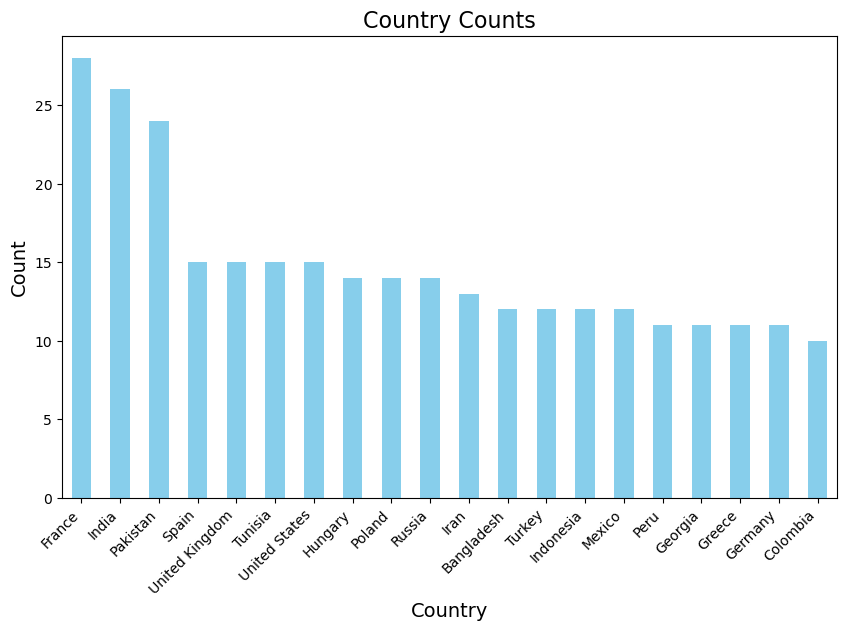

In [6]:
country_counts = data['Country'].value_counts()

# 1) ====== Classic bar chart =========
# Plotting the top 10 bar chart
plt.figure(figsize=(10, 6))  
country_counts.head(20).plot(kind='bar', color='skyblue')

plt.title('Country Counts', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right') # rotating x-axis labels for better readability
plt.show()

# 1) ====== More advanced world map =========
country_counts_df = country_counts.reset_index()
country_counts_df.columns = ['Country', 'Count']

# Create the choropleth map
fig = px.choropleth(
    country_counts_df,
    locations='Country',
    locationmode='country names',  
    color='Count',
    color_continuous_scale='viridis',
    title='Country Counts',
    labels={'Count': 'Count'}
)

# Customize the layout
fig.update_layout(
    title_font_size=18,
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth')
)

# Show the map
fig.show()

2. Date ranges

Latest protest date: 2016-10-01 00:00:00
Newest protest date: 2024-10-01 00:00:00


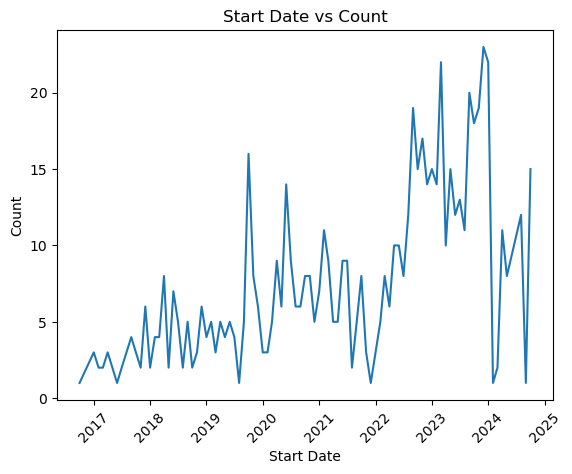

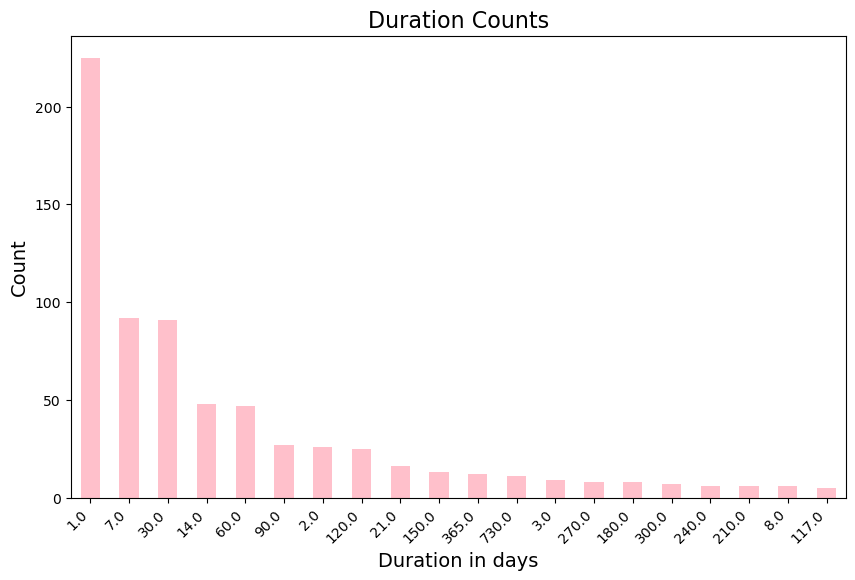

In [7]:
# 1) Year ranges
print("Latest protest date:",data['Start Date'].min())
print("Newest protest date:",data['Start Date'].max())

# 2) Protest Frequency over time
xpoints = data['Start Date'].value_counts().sort_index().index  # Unique dates (x-axis)
ypoints = data['Start Date'].value_counts().sort_index().values  # Counts (y-axis)

# Plot the data
plt.plot(xpoints, ypoints)
plt.xticks(rotation=45)  # Rotate x-axis labels if dates overlap
plt.title('Start Date vs Count')
plt.xlabel('Start Date')
plt.ylabel('Count')
plt.show()

# 3) Distribution of Duration
plt.figure(figsize=(10, 6))  
data['Duration in days'].value_counts().head(20).plot(kind='bar', color='pink')

# Add titles and labels
plt.title('Duration Counts', fontsize=16)
plt.xlabel('Duration in days', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

4. Peak size distribution

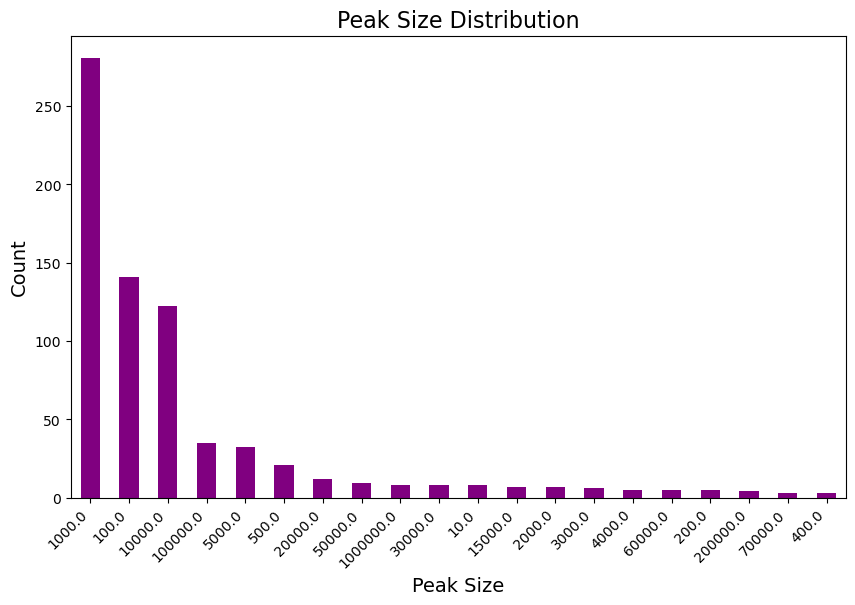

 2    350
 3    169
 1    163
 4     51
 0     21
 5     11
-1      3
 6      1
Name: Size category, dtype: int64

In [8]:
plt.figure(figsize=(10, 6))  
data['Peak Size'].value_counts().head(20).plot(kind='bar', color='purple')

# Add titles and labels
plt.title('Peak Size Distribution', fontsize=16)
plt.xlabel('Peak Size', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

data['Size category'].value_counts()

Hence, most of the protests were in thousands (348), then tens of thousands (169) and hundreds (163). The data is less representative of protests which concerned hundreds of thousands of protesters (51), tens (21), over one million (5) and only one with tens of millions. There were three protests with an unknown size. This feature was created for a more detailed exploratory data analysis, and will be removed at a later stage for predictions. 

3. Textual data analysis

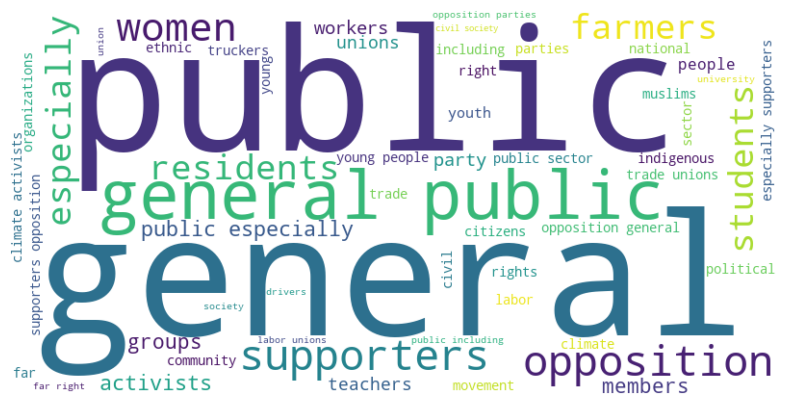

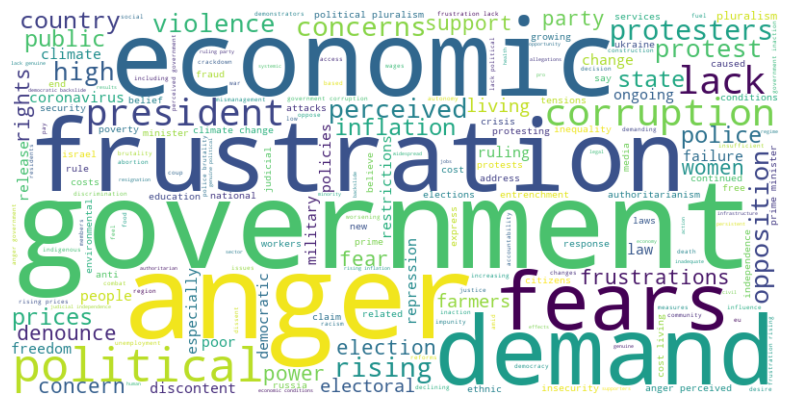

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Function to clean text for later analysis
def clean_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W',' ',text)
    # Lowercase the text
    text = text.lower()
    text = ' '.join(text.split())
    return text

textual_columns = ['Protest Name', 'Key Participants','Triggers', 'Motivations','Outcomes']
tf_idf = data.copy() # Creating a dataframe with preprocessed textual data for tf-idf and leaving 'data' for transformers for more context
for column in textual_columns:
    tf_idf[column] = tf_idf[column].fillna('').astype(str).apply(clean_text)
    tf_idf[column] = tf_idf[column].apply(clean_text)

def word_cloud(data, column):
    # Using a vectorizer for a larger corpus of words to create the word cloud
    corpus = []
    for row in data[column]:
        corpus.append(row)
        
    vectorizer = TfidfVectorizer(strip_accents="ascii", lowercase=True, stop_words='english', ngram_range = (1,2), max_df = 0.99, min_df = 0.01, max_features=1000, norm = 'l2', binary = False)
    vectors = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    dense = vectors.todense() 
    denselist = dense.tolist() 
    df = pd.DataFrame(denselist, columns=feature_names) 
    
    # Step 1: Summing the TF-IDF values for each word (column)
    word_scores = df.sum(axis=0)

    # Step 2: Converting it to a dictionary for the WordCloud
    word_dict = word_scores.to_dict()

    # Step 3: Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)

    # Step 4: Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.show()
    
word_cloud(tf_idf,'Key Participants')
word_cloud(tf_idf,'Motivations')

4. Categorical values analysis

In [10]:
country_counts_df

Country  Count
0                  France     28
1                   India     26
2                Pakistan     24
3                   Spain     15
4          United Kingdom     15
..                    ...    ...
144  United Arab Emirates      1
145            Tajikistan      1
146            Uzbekistan      1
147           El Salvador      1
148    Dominican Republic      1

[149 rows x 2 columns]

In [11]:
political = round(len(data[data['Political motivation?']==1])/len(data),3)
economic = round(len(data[data['Economic motivation?']==1])/len(data),4)
corruption = round(len(data[data['Corruption motivation?']==1])/len(data),3)
significant = data[data['Protests with a significant outcome']==1]
large = round(len(data[data['Large protests (Over 100,000 protesting)']==1])/len(data),3)
violent = round(len(data[data['Violent government response']==1])/len(data),4)
long = round(len(data[data['Long protests (more than 3 months)']==1])/len(data),4)
free = round(len(data[data['Free']==1])/len(data),3)

print(f"{political*100}% of the protests had a political motivation.")
print(f"{economic*100}% of the protests had an economic motivation.")
print(f"{corruption*100}% of the protests had a corruption motivation.")
print(f"{large*100}% of the protests had more than 100k protesters.")
print(f"{violent*100}% of the protests were met with a violent response.")
print(f"{long*100}% of the protests lasted for more than 3 months.")
print(f"{free*100}% of the protests were labeled as 'free'.")
print(f"{(round(len(significant)/len(data),2))*100}% of the protests had a significant outcome. \n")

# Analyzing the geographic distribution of protests with a significant outcome
# based on the number of protests registered in that country
significant_counts = significant['Country'].value_counts()
def calculating_ratio(row):
    country = row['Country']
    if country not in significant_counts:
        return pd.Series({'Significant Count': 0, 'Significance ratio': 0})
    else:
        #print(significant_counts[country])
        #print(country_counts[country])
        ratio = round((significant_counts[country]/country_counts[country]),2)
        return pd.Series({'Significant Count': significant_counts[country], 'Significance ratio': ratio})

country_counts_df[['Significant Count','Significance ratio']] = country_counts_df.apply(calculating_ratio, axis=1)
# Taking into account protest with more than 10 protests 
country_counts_df[country_counts_df['Count'] > 10].sort_values(by='Significance ratio', ascending=False).head(20)

85.2% of the protests had a political motivation.
35.5% of the protests had an economic motivation.
14.6% of the protests had a corruption motivation.
8.7% of the protests had more than 100k protesters.
20.68% of the protests were met with a violent response.
17.43% of the protests lasted for more than 3 months.
37.6% of the protests were labeled as 'free'.
24.0% of the protests had a significant outcome. 



Country  Count  Significant Count  Significance ratio
15            Peru     11                5.0                0.45
8           Poland     14                5.0                0.36
6    United States     15                5.0                0.33
1            India     26                8.0                0.31
2         Pakistan     24                7.0                0.29
17          Greece     11                3.0                0.27
11      Bangladesh     12                3.0                0.25
12          Turkey     12                3.0                0.25
13       Indonesia     12                3.0                0.25
10            Iran     13                3.0                0.23
3            Spain     15                3.0                0.20
5          Tunisia     15                3.0                0.20
0           France     28                4.0                0.14
4   United Kingdom     15                2.0                0.13
16         Georgia     11                1.0                0.09
18         Germany     11                1.0                0.09
7          Hungary     14                1.0                0.07
9           Russia     14                1.0                0.07
14          Mexico     12                0.0                0.00

Data analysis of protests with significant outcome

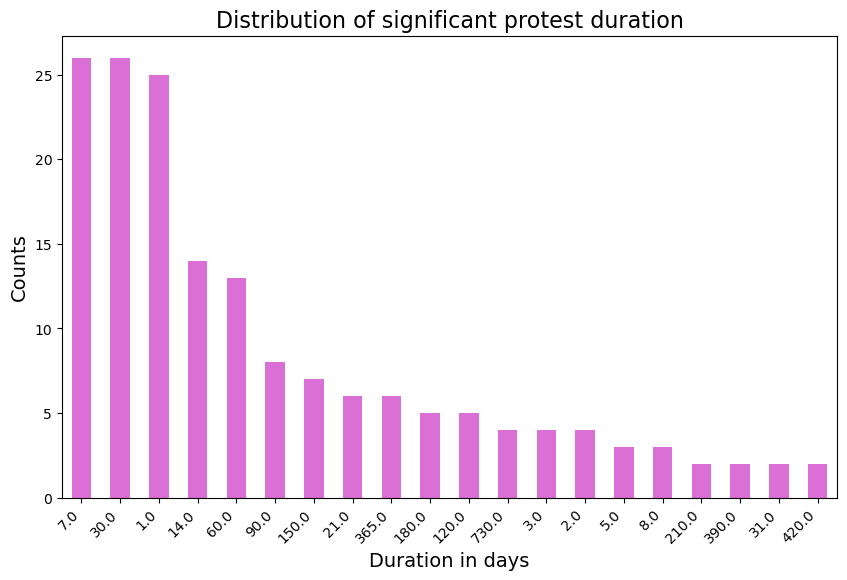

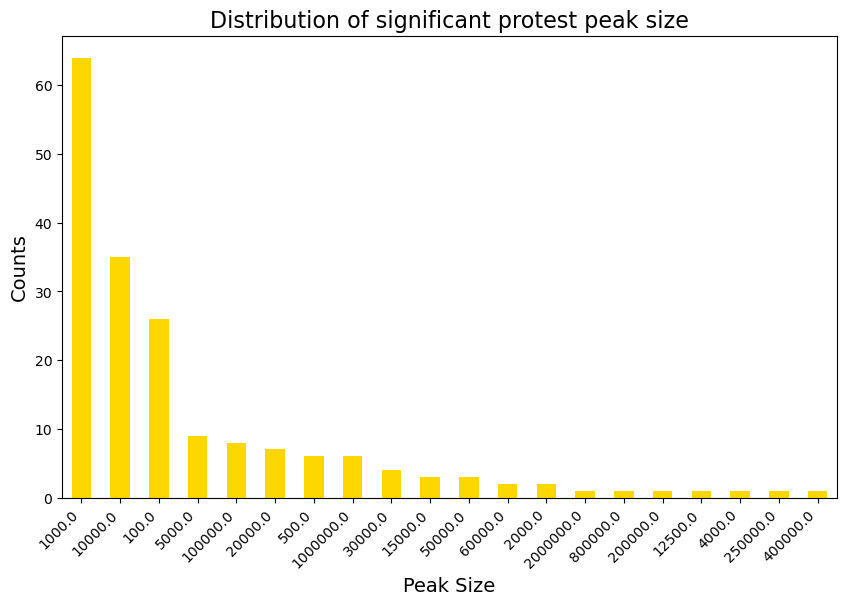

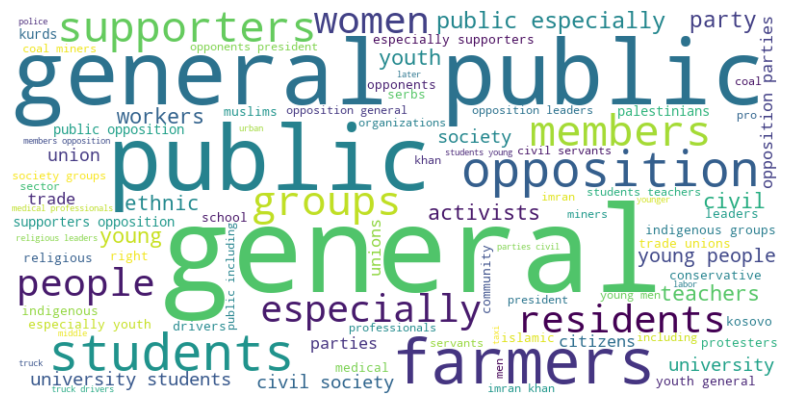

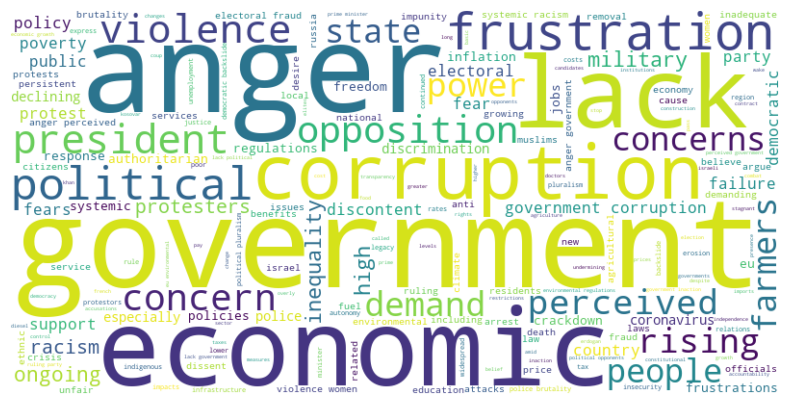

In [12]:
def plot_hist(data, title, xlabel, color_):
    plt.figure(figsize=(10, 6))  
    data.value_counts().head(20).plot(kind='bar', color=color_)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.show()  

plot_hist(significant['Duration in days'], 'Distribution of significant protest duration',
          'Duration in days', 'orchid')
plot_hist(significant['Peak Size'], 'Distribution of significant protest peak size',
          'Peak Size', 'gold')
word_cloud(significant,'Key Participants')
word_cloud(significant,'Motivations')

# Feature Engineering

In [13]:
# dropping 'Key Participants' column as it is redundant when adding the topic of the protest at a later stage
data = data.drop(columns = ['Start Date','Freedom Rating (Status)','Key Participants', 'Size category', 'Capital city'], axis=1)
data.dropna(subset=['Outcomes'],inplace=True)
data.isnull().sum()

Country                                     0
Protest Name                                0
Triggers                                    0
Motivations                                 0
Peak Size                                   0
Outcomes                                    0
Active protests                             0
Economic motivation?                        0
Political motivation?                       0
Corruption motivation?                      0
Protests with a significant outcome         0
Large protests (Over 100,000 protesting)    0
Violent government response                 0
Long protests (more than 3 months)          0
Coronavirus-related protests                0
Duration in days                            0
Free                                        0
dtype: int64

## Topic Modeling
### Identifying protest themes

In [14]:
names_triggers = tf_idf['Protest Name'] + ": " + tf_idf['Triggers']
names_triggers[1]

'2024 general elections protest: the opposition candidate venâncio mondlane called for a nationwide strike to dispute the provisional election results which showed that the ruling party frelimo was likely to win two days before the planned demonstration two opposition figures were killed'

In [ ]:
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(names_triggers)

In [24]:
topics_with_count = topic_model.get_topic_info()
topics_with_count = topics_with_count.sort_values(by='Count',ascending=False)
topics_with_count

Topic  Count                                          Name  \
1       0    224                 0_protests_protest_costs_cost   
0      -1    163      -1_protests_protest_opposition_elections   
2       1     81     1_elections_election_electoral_reelection   
3       2     79           2_protests_protest_racism_brutality   
4       3     44          3_protests_protest_protesters_arrest   
5       4     32       4_coronavirus_vaccination_vaccine_covid   
6       5     31         5_farmers_farms_agricultural_farmland   
7       6     26           6_protests_protest_serbs_amendments   
8       7     22             7_protests_protest_violence_raped   
9       8     22       8_corruption_protests_protest_political   
10      9     22           9_ukraine_blockade_ukrainian_border   
11     10     12        10_abortion_abortions_protests_protest   
12     11     11  11_immigration_deportations_protests_protest   

                                       Representation  \
1   [protests, protest, costs, cost, subsidies, pr...   
0   [protests, protest, opposition, elections, dem...   
2   [elections, election, electoral, reelection, p...   
3   [protests, protest, racism, brutality, floyd, ...   
4   [protests, protest, protesters, arrest, arrest...   
5   [coronavirus, vaccination, vaccine, covid, res...   
6   [farmers, farms, agricultural, farmland, lives...   
7   [protests, protest, serbs, amendments, kosovo,...   
8   [protests, protest, violence, raped, women, ra...   
9   [corruption, protests, protest, political, par...   
10  [ukraine, blockade, ukrainian, border, azerbai...   
11  [abortion, abortions, protests, protest, roe, ...   
12  [immigration, deportations, protests, protest,...   

                                  Representative_Docs  
1   [cost of living protest: rapidly rising prices...  
0   [ayotzinapa students protest for justice: in 2...  
2   [presidential election results protest: the in...  
3   [black lives matter protests: death of george ...  
4   [opposition leader arrest protests: the arrest...  
5   [coronavirus restriction protests: the imposit...  
6   [farmers protest 2024: the eu waived duties an...  
7   [criminal code protests: consideration of a ne...  
8   [violence against women protest: 22 year old s...  
9   [corruption protests: revelations that state n...  
10  [peace plan protests: announcement of a russia...  
11  [abortion rights protests: a ruling by poland ...  
12  [anti immigration bill protest: the french gov...

In [25]:
topic_model.visualize_topics()

In [26]:
topics = topic_model.get_document_info(tf_idf['Protest Name'])
topics[:3]

Document  Topic  \
0  protest against removal of opposition mayor     -1   
1               2024 general elections protest      1   
2                           anti rama protests      3   

                                        Name  \
0   -1_protests_protest_opposition_elections   
1  1_elections_election_electoral_reelection   
2       3_protests_protest_protesters_arrest   

                                      Representation  \
0  [protests, protest, opposition, elections, dem...   
1  [elections, election, electoral, reelection, p...   
2  [protests, protest, protesters, arrest, arrest...   

                                 Representative_Docs  \
0  [ayotzinapa students protest for justice: in 2...   
1  [presidential election results protest: the in...   
2  [opposition leader arrest protests: the arrest...   

                                         Top_n_words  Probability  \
0  protests - protest - opposition - elections - ...     0.000000   
1  elections - election - electoral - reelection ...     0.634257   
2  protests - protest - protesters - arrest - arr...     0.869466   

   Representative_document  
0                    False  
1                    False  
2                    False

Looking at the correlation between features to delete highly correlated features.

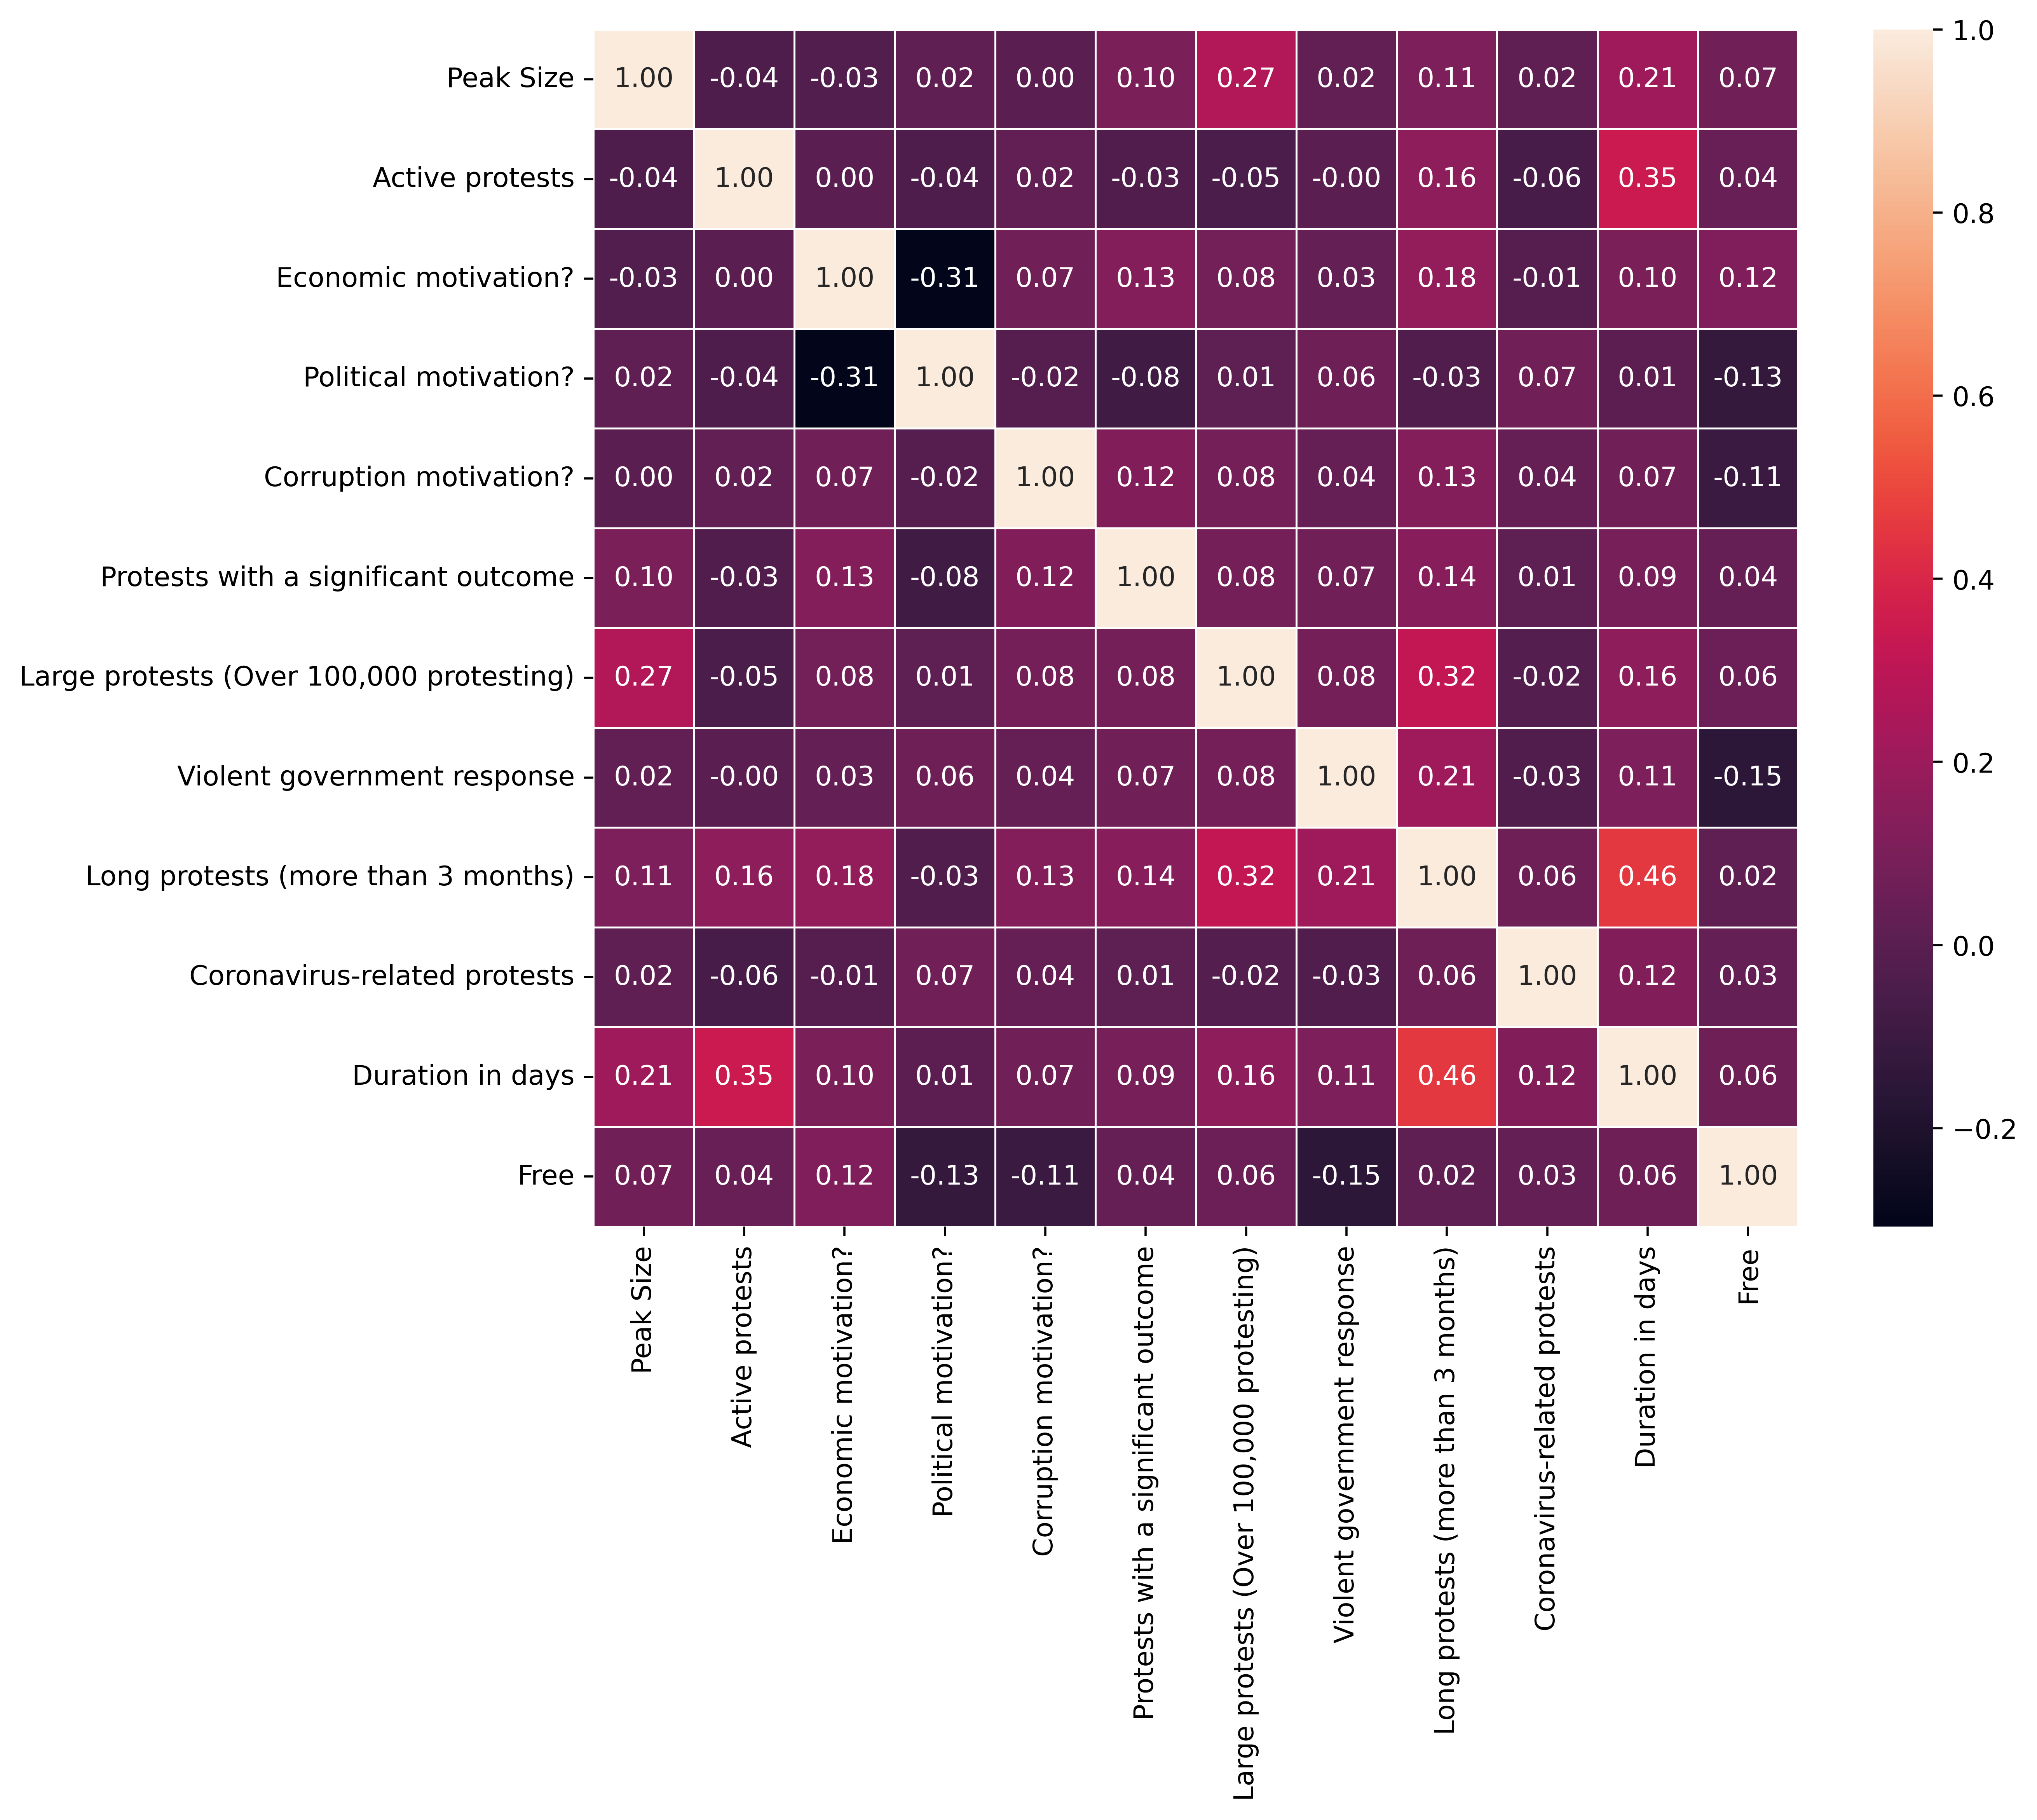

In [28]:
import seaborn as sns

# Find the pearson correlations matrix
corr = data.corr(method = 'pearson')
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

'Size category' is highly correlated with 'Large protests (Over 100,000 protesting)', 'Duration in days' with 'Long protests (more than 3 months)' which makes sense. Hence, I will proceed with dropping these features from the data frame. No feature is significantly related with the 'significant outcome' feature. Let's check if the topic plays any role.

In [27]:
data = data.drop(columns=['Large protests (Over 100,000 protesting)','Long protests (more than 3 months)'])

topics_to_merge = topics.drop(columns=['Document',
                                       'Name',
                                       'Representation',
                                       'Representative_Docs',
                                       'Top_n_words',
                                       'Probability',
                                       'Representative_document'])

# Combine using concat() along columns
significant_outcome = data['Protests with a significant outcome']
topic_corr = pd.concat([significant_outcome, topics_to_merge], axis=1, ignore_index=False)

One-hot encoding of the topics

In [28]:
# Ensuring all data points of the Topic column are of type int
topic_corr['Topic'] = topic_corr['Topic'].astype(int)  

# Automatically generating a binary column for each unique value in the Topic column
binary_columns = pd.get_dummies(topic_corr['Topic'], prefix='Topic', dtype = int)

# Add the binary columns to the original DataFrame
topic_corr = pd.concat([topic_corr, binary_columns], axis=1)
topic_corr = topic_corr.drop(columns=['Topic'])
topic_corr[:3]

Protests with a significant outcome  Topic_-1  Topic_0  Topic_1  Topic_2  \
0                                  0.0         1        0        0        0   
1                                  0.0         0        0        1        0   
2                                  0.0         0        0        0        0   

   Topic_3  Topic_4  Topic_5  Topic_6  Topic_7  Topic_8  Topic_9  Topic_10  \
0        0        0        0        0        0        0        0         0   
1        0        0        0        0        0        0        0         0   
2        1        0        0        0        0        0        0         0   

   Topic_11  
0         0  
1         0  
2         0

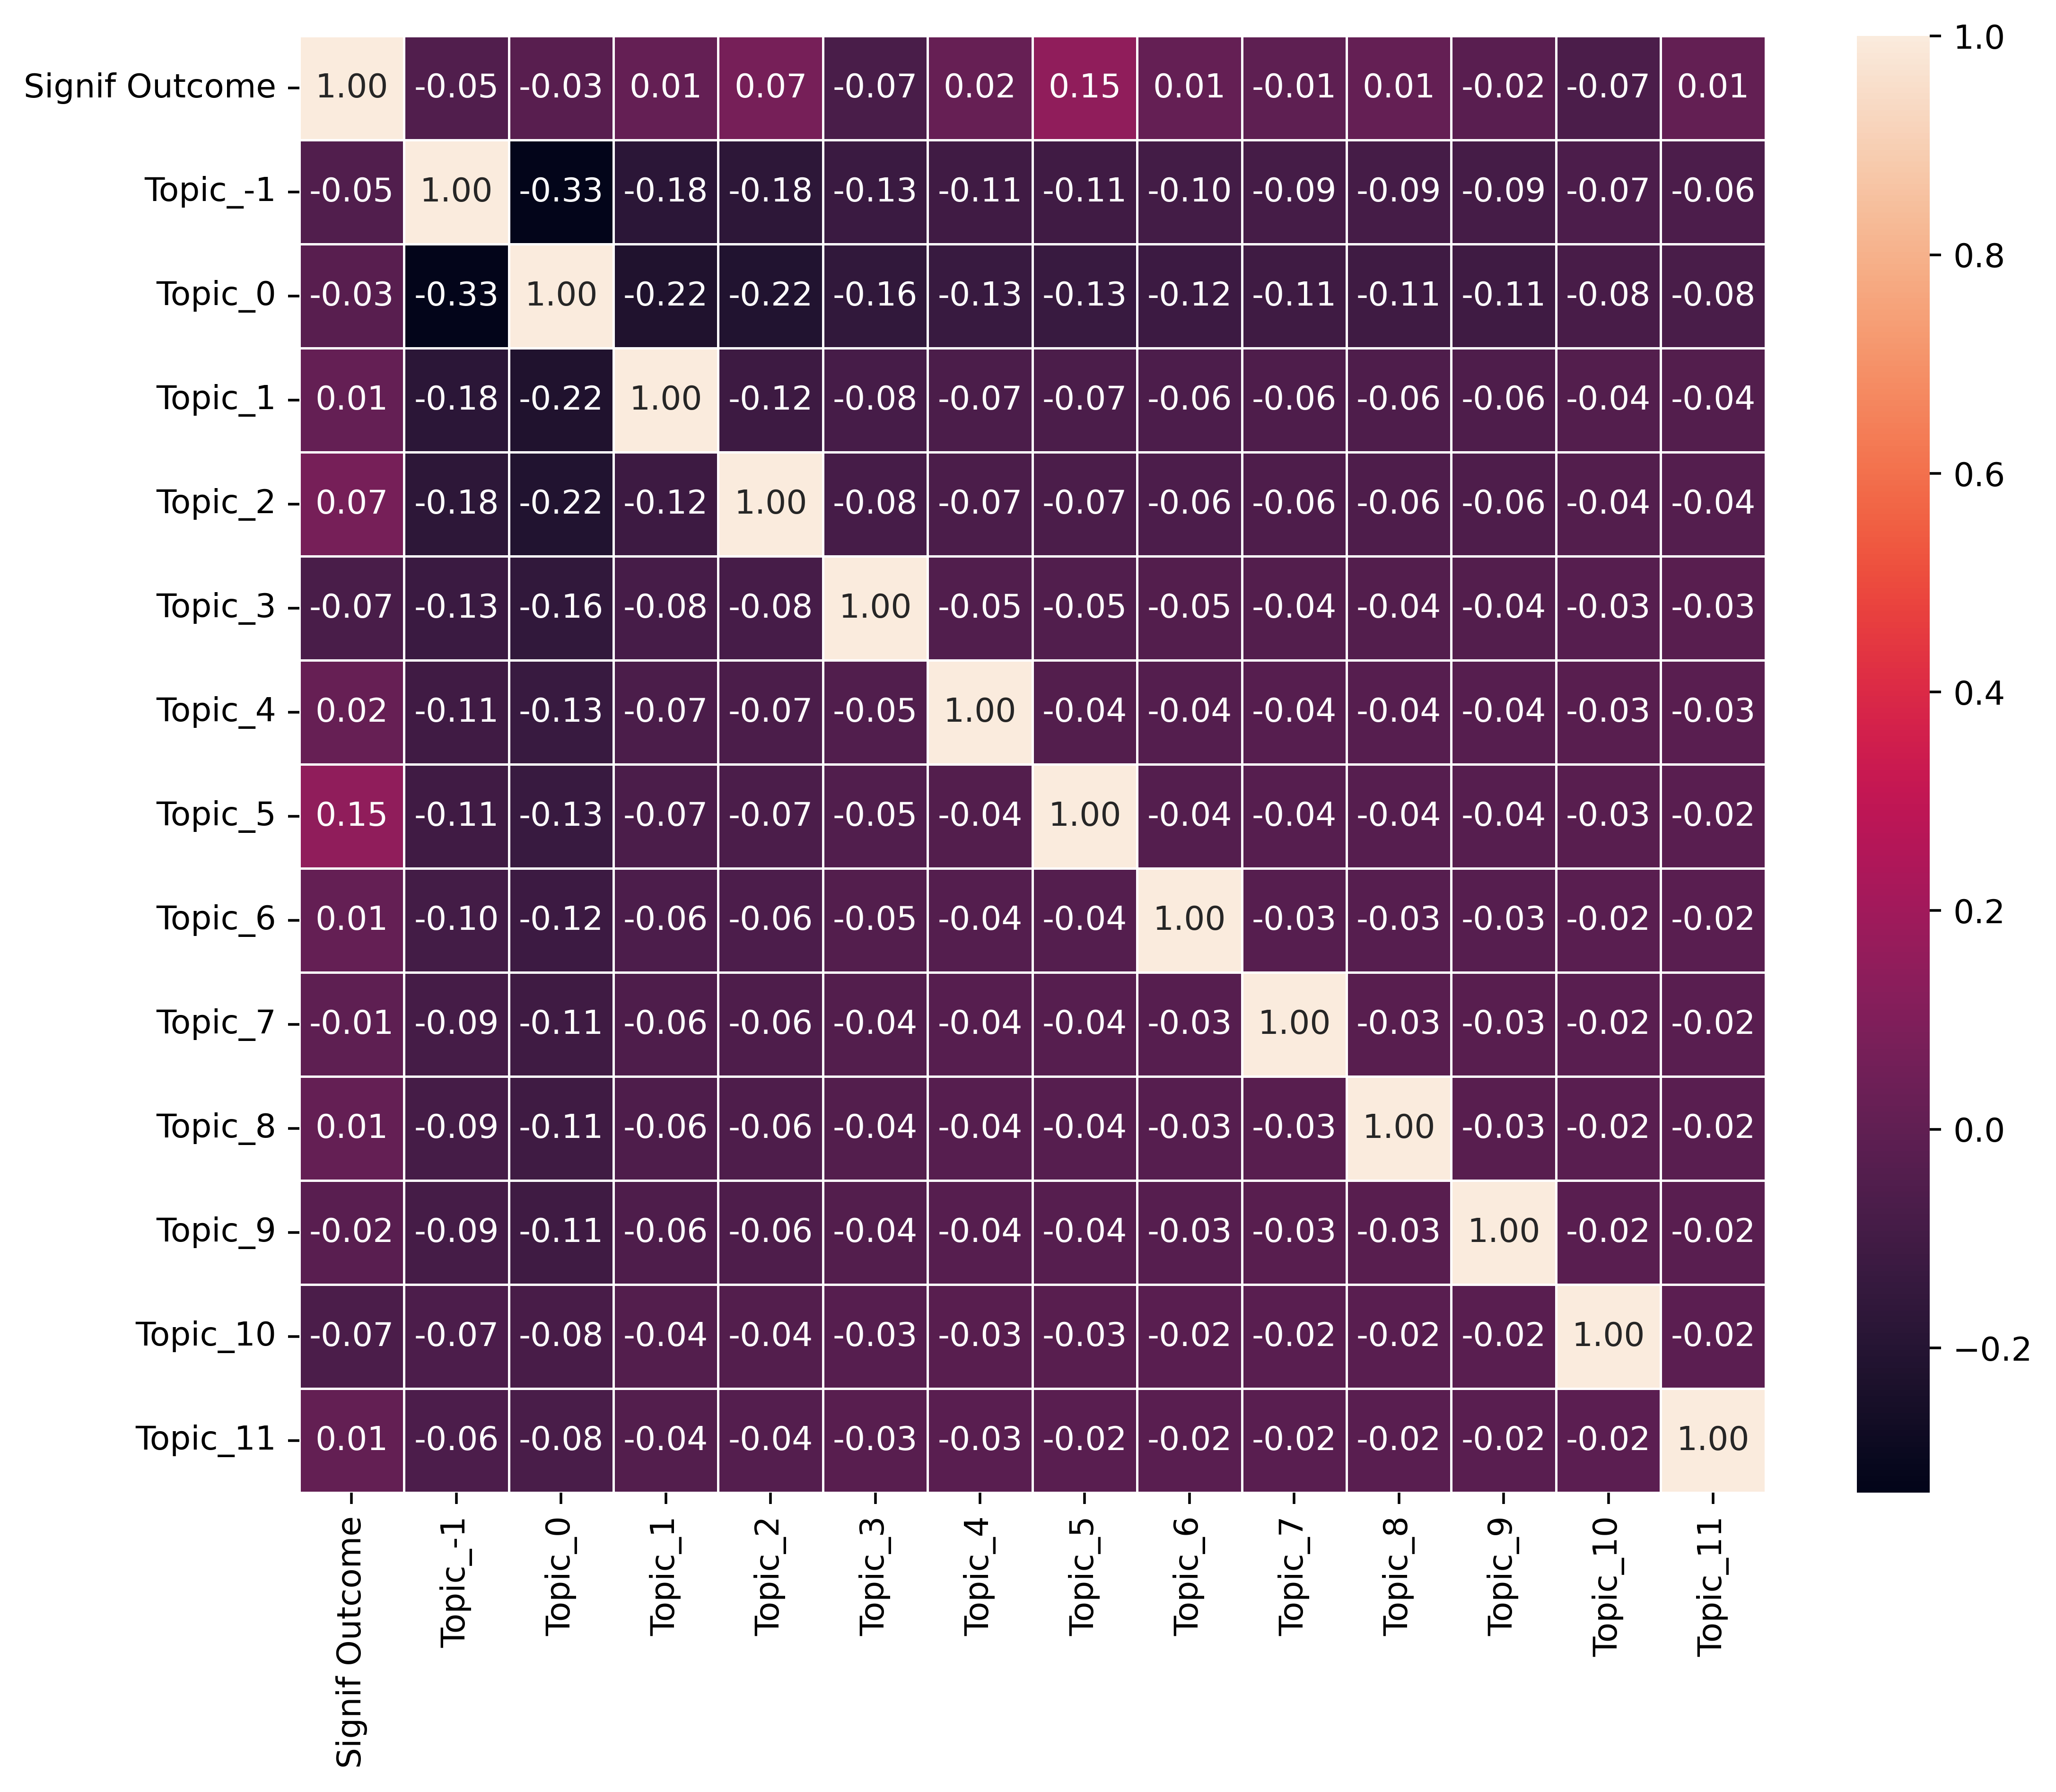

In [33]:
import seaborn as sns
# Printing the heatmap of the correlation matrix
topic_corr.rename(columns={'Protests with a significant outcome': 'Signif Outcome'}, inplace=True)
corr = topic_corr.corr(method = 'pearson')
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [31]:
# Keeping only the topic that is the most correlated with our target variable
max_corr = 0
max_topic = ''
sign_list = corr['Protests with a significant outcome'][1:]
indexes = sign_list.index

for i in range(len(sign_list)):
    curr_corr = sign_list[i]
    if curr_corr > max_corr:
        max_corr = curr_corr
        max_topic = indexes[i]
    else:
        continue

print(max_topic, max_corr)

data = pd.concat([data,topic_corr[max_topic]],axis=1)
data[:1]

Topic_5 0.1465868367133065


Country                                 Protest Name  \
0  Türkiye  Protest against removal of opposition mayor   

                                            Triggers  \
0  Ahmet Özer, the mayor of Istanbul's Esenyurt d...   

                                         Motivations  Peak Size  \
0  Denounce Özer's removal from office as a polit...      100.0   

                      Outcomes  Active protests  Economic motivation?  \
0  No policy/leadership change              1.0                   0.0   

   Political motivation?  Corruption motivation?  \
0                    1.0                     1.0   

   Protests with a significant outcome  Violent government response  \
0                                  0.0                          0.0   

   Coronavirus-related protests  Duration in days  Free  Topic_5  
0                           0.0             117.0   0.0        0

In [32]:
data = data.drop(columns=['Active protests','Country','Protest Name','Coronavirus-related protests'])
data.columns

Index(['Triggers', 'Motivations', 'Peak Size', 'Outcomes',
       'Economic motivation?', 'Political motivation?',
       'Corruption motivation?', 'Protests with a significant outcome',
       'Violent government response', 'Duration in days', 'Free', 'Topic_5'],
      dtype='object')

## Prediction - Part 1

In the first part, I will build a model predicting the 'significant outcome' feature. 

Normalizing values of non-binary columns

In [34]:
from sklearn.preprocessing import StandardScaler
 
columns_to_normalize = ['Peak Size', 'Duration in days']
scaler = StandardScaler()
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

In [35]:
data.dropna(subset=['Peak Size', 'Duration in days'],inplace=True)
data[['Peak Size', 'Duration in days']].isnull().sum()

Peak Size           0
Duration in days    0
dtype: int64

In [36]:
data[['Peak Size', 'Duration in days']]

Peak Size  Duration in days
0    -0.217265          0.174822
1    -0.212339          0.174822
2    -0.212339          0.174822
3    -0.163077          0.174822
4     0.329541         -0.459636
..         ...               ...
764  -0.212339         -0.136938
765   0.329541          2.843921
766  -0.053606         -0.459636
767   0.876895          0.027146
768   7.992495          0.355314

[768 rows x 2 columns]

In [91]:
# will drop the target variable at a later stage
X = data.drop(['Triggers', 'Motivations','Outcomes','Protests with a significant outcome'],axis=1)
y = data['Protests with a significant outcome']
X

Peak Size  Economic motivation?  Political motivation?  \
0    -0.217265                   0.0                    1.0   
1    -0.212339                   0.0                    1.0   
2    -0.212339                   0.0                    1.0   
3    -0.163077                   0.0                    1.0   
4     0.329541                   0.0                    1.0   
..         ...                   ...                    ...   
764  -0.212339                   1.0                    0.0   
765   0.329541                   1.0                    1.0   
766  -0.053606                   1.0                    1.0   
767   0.876895                   0.0                    1.0   
768   7.992495                   0.0                    1.0   

     Corruption motivation?  Violent government response  Duration in days  \
0                       1.0                          0.0          0.174822   
1                       1.0                          1.0          0.174822   
2                       1.0                          0.0          0.174822   
3                       1.0                          0.0          0.174822   
4                       0.0                          0.0         -0.459636   
..                      ...                          ...               ...   
764                     1.0                          0.0         -0.136938   
765                     1.0                          0.0          2.843921   
766                     1.0                          0.0         -0.459636   
767                     0.0                          0.0          0.027146   
768                     0.0                          0.0          0.355314   

     Free  Topic_5  
0     0.0        0  
1     0.0        0  
2     0.0        0  
3     0.0        0  
4     1.0        0  
..    ...      ...  
764   0.0        0  
765   0.0        1  
766   1.0        0  
767   0.0        0  
768   1.0        0  

[768 rows x 8 columns]

### Hyperparameter Tuning

1. Decision Tree

In [39]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(X,y)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 5}


2. Random Forest

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

clf = RandomForestClassifier(n_estimators=50)

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

samples = 8  # number of random samples 
randomCV = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=samples,cv=3)

randomCV.fit(X, y)
print(randomCV.best_params_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 7, 'min_samples_split': 8}


3. XGBoost

In [42]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

param_dist = {
    'max_depth': stats.randint(3, 15),
    'learning_rate': [0.05,0.10,0.15,0.20,0.25,0.30],
    'subsample': stats.uniform(0.5, 0.5),
    'min_child_weight' : [1,3,5,7],
    'gamma': [0.0,0.1,0.2,0.3,0.4],
    'n_estimators':stats.randint(50, 200),
    'colsample_bytree' : [0.3,0.4,0.5,0.7]
}


xgb_model = xgb.XGBClassifier()
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')
random_search.fit(X, y)
print("Best set of hyperparameters: ", random_search.best_params_)

Best set of hyperparameters:  {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 68, 'subsample': 0.8563277359652208}


In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from array import array
import shap

def prediction(X,y,test_size, shuffle_, model):
    # I do this to compare results for both cases: with shuffling and without 
    if shuffle_:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False) #For some reason I did the opposite, so True means False and vice versaŚ
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
    # Identify rows to duplicate based on the target variable
    rows_to_duplicate = X_train[y_train == 1]
    
    # Duplicate the rows in both X_train and y_train
    X_train = pd.concat([X_train, rows_to_duplicate, rows_to_duplicate], ignore_index=True)
    y_train = pd.concat([y_train, y_train[y_train == 1], y_train[y_train == 1]], ignore_index=True)
    
    # Looking at the distribution of the target variable after duplication
    print(f"For a test size of {test_size} the distribution of the target variable after duplication is:\n {y_train.value_counts()}")
     
    if model == 'xgb':
        xgb_model = xgb.XGBClassifier(colsample_bytree=0.7, 
                                      gamma= 0.3, learning_rate= 0.05, 
                                      max_depth= 9, min_child_weight= 7, 
                                      n_estimators= 68, subsample= 0.8563277359652208)
        
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict_proba(X_test)
        
        # Get the feature importance scores
        feature_importance = xgb_model.feature_importances_
        importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
        importance_df = importance_df.sort_values('Importance', ascending=False)
        print(importance_df)
        
    elif model == 'rf':
        # Random forest model based on the best identified hyperparameters
        rf = RandomForestClassifier(n_estimators=50, bootstrap=True, criterion='gini', max_depth=3, max_features=3,
                            min_samples_leaf=7, min_samples_split=8)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_test)
        
    elif model == 'dt':
        dt = DecisionTreeClassifier(criterion="gini", max_depth=3, 
                               max_features=7,min_samples_leaf=5)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_test)
        
    y_pred = pd.DataFrame(y_pred)
    y_test = np.array(y_test)
    return y_pred, y_test

def choose_threshold(y_pred_model,y_test):
    # Transforming the data frame of positive probabilities into an array for later operations
    y_pred_negative = y_pred_model[0]
    
    # Performing a Grid Search to determine the best threshold
    best_threshold = 0
    best_score = 0
    accuracy_ = 0
    
    for threshold in np.arange(0, 1, 0.01):
        y_pred_temp = (y_pred_negative < threshold).astype(int) # Goes through the whole array and returns 1 or 0 based on the threshold
        score = f1_score(y_test, y_pred_temp)
        if score > best_score:
            best_score = score
            accuracy_ = accuracy_score(y_test, y_pred_temp)
            best_threshold = threshold
            
    print(f"Best threshold: {best_threshold}, Best f1-score: {best_score} ,best accuracy: {accuracy_}")
    return best_threshold


def evaluate(y_pred, best_threshold, y_test):
    # Taking only the predictions for the label '1' (as it is the same as '0' but substracting 1)
    if len(y_pred.columns) > 1:
        predictions = y_pred[1]
    else:
        predictions = y_pred
    # Getting predictions based on the best threshold
    y_pred_binary = np.where(predictions >= (1 - best_threshold), 1, 0)
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    
    results = {'Accuracy': accuracy,
               'Precision': precision,
               'Recall': recall,
               'f1': f1}
    
    return y_pred_binary, results

def create_confusion_matrix(y_test, y_pred_binary):
    cm = confusion_matrix(y_test, y_pred_binary)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # Adding labels to the confusion matrix squares
    class_names = ['Negative', 'Positive']
    tick_marks = [0.5, 1.5]
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

In [93]:
# Creating dictionaries to save the results
xgb_dict = {'0.4_Shuffle_True':[],'0.3_Shuffle_True':[],'0.2_Shuffle_True':[],'0.4_Shuffle_False':[],'0.3_Shuffle_False':[],'0.2_Shuffle_False':[]}
dt_dict= {'0.4_Shuffle_True':[],'0.3_Shuffle_True':[],'0.2_Shuffle_True':[],'0.4_Shuffle_False':[],'0.3_Shuffle_False':[],'0.2_Shuffle_False':[]}
rf_dict = {'0.4_Shuffle_True':[],'0.3_Shuffle_True':[],'0.2_Shuffle_True':[],'0.4_Shuffle_False':[],'0.3_Shuffle_False':[],'0.2_Shuffle_False':[]}

best_model = ''
best_f1_score = 0
best_accuracy = 0
best_precision = 0
best_recall = 0

def assess_best_model(results, model_param, best_f1_score, best_accuracy, best_precision, best_recall, best_model):
    if results['f1'] > best_f1_score:
        best_f1_score = results['f1']
        best_model = model_param
        best_accuracy = results['Accuracy']
        best_precision = results['Precision']
        best_recall = results['Recall']
    return best_f1_score, best_accuracy, best_precision, best_recall, best_model

### Test size = 0.4

First model - XGBoost

In [94]:
y_pred_xgb_40_False, y_test_xgb_40_False = prediction(X,y,0.4,False,'xgb')
best_threshold_xgb = choose_threshold(y_pred_xgb_40_False, y_test_xgb_40_False)
y_pred_binary_xgb_40_False, results = evaluate(y_pred_xgb_40_False, best_threshold_xgb, y_test_xgb_40_False)
xgb_dict['0.4_Shuffle_False'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'xgb_40_False',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.4 the distribution of the target variable after duplication is:
 0.0    346
1.0    342
Name: Protests with a significant outcome, dtype: int64
                       Feature  Importance
7                      Topic_5    0.322783
3       Corruption motivation?    0.172515
5             Duration in days    0.129927
1         Economic motivation?    0.105022
4  Violent government response    0.097141
0                    Peak Size    0.087298
6                         Free    0.047050
2        Political motivation?    0.038263
Best threshold: 0.55, Best f1-score: 0.43290043290043295 ,best accuracy: 0.5746753246753247


Second model: Decision Tree

In [95]:
y_pred_dt_40_False, y_test_dt_40_False = prediction(X,y,0.4,False,'dt')
best_threshold_dt = choose_threshold(y_pred_dt_40_False, y_test_dt_40_False)
y_pred_binary_dt_40_False, results = evaluate(y_pred_dt_40_False, best_threshold_dt, y_test_dt_40_False)
dt_dict['0.4_Shuffle_False'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'dt_40_False',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.4 the distribution of the target variable after duplication is:
 0.0    356
1.0    312
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.52, Best f1-score: 0.45484949832775917 ,best accuracy: 0.4707792207792208


Third model: Random Forest

In [96]:
y_pred_rf_40_False, y_test_rf_40_False = prediction(X,y,0.4,False,'rf')
best_threshold_rf = choose_threshold(y_pred_rf_40_False, y_test_rf_40_False)
y_pred_binary_rf_40_False, results = evaluate(y_pred_rf_40_False, best_threshold_rf, y_test_rf_40_False)
rf_dict['0.4_Shuffle_False'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'rf_40_False',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.4 the distribution of the target variable after duplication is:
 0.0    354
1.0    318
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.66, Best f1-score: 0.46 ,best accuracy: 0.474025974025974


### Test size = 0.3

In [97]:
y_pred_xgb_30_False, y_test_xgb_30_False = prediction(X,y,0.3,False,'xgb')
best_threshold_xgb = choose_threshold(y_pred_xgb_30_False, y_test_xgb_30_False)
y_pred_binary_xgb_30_False, results = evaluate(y_pred_xgb_30_False, best_threshold_xgb, y_test_xgb_30_False)
xgb_dict['0.3_Shuffle_False'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'xgb_30_False',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.3 the distribution of the target variable after duplication is:
 1.0    408
0.0    401
Name: Protests with a significant outcome, dtype: int64
                       Feature  Importance
7                      Topic_5    0.258749
3       Corruption motivation?    0.178677
5             Duration in days    0.127756
0                    Peak Size    0.111933
1         Economic motivation?    0.092334
2        Political motivation?    0.085882
4  Violent government response    0.078449
6                         Free    0.066220
Best threshold: 0.67, Best f1-score: 0.40375586854460094 ,best accuracy: 0.45021645021645024


In [98]:
y_pred_dt_30_False, y_test_dt_30_False = prediction(X,y,0.3,False,'dt')
best_threshold_dt = choose_threshold(y_pred_dt_30_False, y_test_dt_30_False)
y_pred_binary_dt_30_False, results = evaluate(y_pred_dt_30_False, best_threshold_dt, y_test_dt_30_False)
dt_dict['0.3_Shuffle_False'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'dt_30_False',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.3 the distribution of the target variable after duplication is:
 0.0    404
1.0    399
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.5, Best f1-score: 0.3963963963963964 ,best accuracy: 0.4199134199134199


In [99]:
y_pred_rf_30_False, y_test_rf_30_False = prediction(X,y,0.3,False,'rf')
best_threshold_rf = choose_threshold(y_pred_rf_30_False, y_test_rf_30_False)
y_pred_binary_rf_30_False, results = evaluate(y_pred_rf_30_False, best_threshold_rf, y_test_rf_30_False)
rf_dict['0.3_Shuffle_False'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'rf_30_False',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.3 the distribution of the target variable after duplication is:
 0.0    409
1.0    384
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.5, Best f1-score: 0.49704142011834324 ,best accuracy: 0.6320346320346321


### Test size = 0.2

In [100]:
y_pred_xgb_20_False, y_test_xgb_20_False = prediction(X,y,0.2,False,'xgb')
best_threshold_xgb = choose_threshold(y_pred_xgb_20_False, y_test_xgb_20_False)
y_pred_binary_xgb_20_False, results = evaluate(y_pred_xgb_20_False, best_threshold_xgb, y_test_xgb_20_False)
xgb_dict['0.2_Shuffle_False'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'xgb_20_False',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.2 the distribution of the target variable after duplication is:
 0.0    465
1.0    447
Name: Protests with a significant outcome, dtype: int64
                       Feature  Importance
7                      Topic_5    0.218686
3       Corruption motivation?    0.171251
5             Duration in days    0.138876
2        Political motivation?    0.124968
4  Violent government response    0.106361
1         Economic motivation?    0.092038
0                    Peak Size    0.084561
6                         Free    0.063260
Best threshold: 0.45, Best f1-score: 0.48101265822784806 ,best accuracy: 0.7337662337662337


In [101]:
y_pred_dt_20_False, y_test_dt_20_False = prediction(X,y,0.3,False,'dt')
best_threshold_dt = choose_threshold(y_pred_dt_20_False, y_test_dt_20_False)
y_pred_binary_dt_20_False, results = evaluate(y_pred_dt_20_False, best_threshold_dt, y_test_dt_20_False)
dt_dict['0.2_Shuffle_False'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'dt_20_False',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.3 the distribution of the target variable after duplication is:
 0.0    414
1.0    369
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.54, Best f1-score: 0.45887445887445893 ,best accuracy: 0.4588744588744589


In [102]:
y_pred_rf_20_False, y_test_rf_20_False = prediction(X,y,0.3,False,'rf')
best_threshold_rf = choose_threshold(y_pred_rf_20_False, y_test_rf_20_False)
y_pred_binary_rf_20_False, results = evaluate(y_pred_rf_20_False, best_threshold_rf, y_test_rf_20_False)
rf_dict['0.2_Shuffle_False'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'rf_20_False',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.3 the distribution of the target variable after duplication is:
 1.0    411
0.0    400
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.6, Best f1-score: 0.4360189573459715 ,best accuracy: 0.48484848484848486


### Shuffle = True

In [103]:
y_pred_xgb_40_True, y_test_xgb_40_True = prediction(X,y,0.4,True,'xgb')
best_threshold_xgb = choose_threshold(y_pred_xgb_40_True, y_test_xgb_40_True)
y_pred_binary_xgb_40_True, results = evaluate(y_pred_xgb_40_True, best_threshold_xgb, y_test_xgb_40_True)
xgb_dict['0.4_Shuffle_True'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'xgb_40_True',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.4 the distribution of the target variable after duplication is:
 0.0    369
1.0    273
Name: Protests with a significant outcome, dtype: int64
                       Feature  Importance
7                      Topic_5    0.328682
4  Violent government response    0.129517
5             Duration in days    0.127133
1         Economic motivation?    0.113941
3       Corruption motivation?    0.083160
6                         Free    0.080658
0                    Peak Size    0.080345
2        Political motivation?    0.056565
Best threshold: 0.65, Best f1-score: 0.5272727272727272 ,best accuracy: 0.4935064935064935


In [104]:
y_pred_dt_40_True, y_test_dt_40_True = prediction(X,y,0.4,True,'dt')
best_threshold_dt = choose_threshold(y_pred_dt_40_True, y_test_dt_40_True)
y_pred_binary_dt_40_True, results = evaluate(y_pred_dt_40_True, best_threshold_dt, y_test_dt_40_True)
dt_dict['0.4_Shuffle_True'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'dt_40_True',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.4 the distribution of the target variable after duplication is:
 0.0    369
1.0    273
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.5700000000000001, Best f1-score: 0.4829545454545454 ,best accuracy: 0.4090909090909091


In [105]:
y_pred_rf_40_True, y_test_rf_40_True = prediction(X,y,0.4,True,'rf')
best_threshold_rf = choose_threshold(y_pred_rf_40_True, y_test_rf_40_True)
y_pred_binary_rf_40_True, results = evaluate(y_pred_rf_40_True, best_threshold_rf, y_test_rf_40_True)
rf_dict['0.4_Shuffle_True'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'rf_40_True',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.4 the distribution of the target variable after duplication is:
 0.0    369
1.0    273
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.68, Best f1-score: 0.5054945054945055 ,best accuracy: 0.4155844155844156


In [106]:
y_pred_xgb_30_True, y_test_xgb_30_True = prediction(X,y,0.3,True,'xgb')
best_threshold_xgb = choose_threshold(y_pred_xgb_30_True, y_test_xgb_30_True)
y_pred_binary_xgb_30_True, results = evaluate(y_pred_xgb_30_True, best_threshold_xgb, y_test_xgb_30_True)
xgb_dict['0.3_Shuffle_True'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'xgb_30_True',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.3 the distribution of the target variable after duplication is:
 0.0    431
1.0    318
Name: Protests with a significant outcome, dtype: int64
                       Feature  Importance
7                      Topic_5    0.319808
5             Duration in days    0.149903
4  Violent government response    0.132606
1         Economic motivation?    0.111046
0                    Peak Size    0.078106
6                         Free    0.077262
3       Corruption motivation?    0.073306
2        Political motivation?    0.057962
Best threshold: 0.68, Best f1-score: 0.550185873605948 ,best accuracy: 0.47619047619047616


In [107]:
y_pred_dt_30_True, y_test_dt_30_True = prediction(X,y,0.3,True,'dt')
best_threshold_dt = choose_threshold(y_pred_dt_30_True, y_test_dt_30_True)
y_pred_binary_dt_30_True, results = evaluate(y_pred_dt_30_True, best_threshold_dt, y_test_dt_30_True)
dt_dict['0.3_Shuffle_True'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'dt_30_True',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.3 the distribution of the target variable after duplication is:
 0.0    431
1.0    318
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.53, Best f1-score: 0.510948905109489 ,best accuracy: 0.4199134199134199


In [108]:
y_pred_rf_30_True, y_test_rf_30_True = prediction(X,y,0.3,True,'rf')
best_threshold_rf = choose_threshold(y_pred_rf_30_True, y_test_rf_30_True)
y_pred_binary_rf_30_True, results = evaluate(y_pred_rf_30_True, best_threshold_rf, y_test_rf_30_True)
rf_dict['0.3_Shuffle_True'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'rf_30_True',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.3 the distribution of the target variable after duplication is:
 0.0    431
1.0    318
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.73, Best f1-score: 0.5263157894736842 ,best accuracy: 0.4155844155844156


In [109]:
y_pred_xgb_20_True, y_test_xgb_20_True = prediction(X,y,0.2,True,'xgb')
best_threshold_xgb = choose_threshold(y_pred_xgb_20_True, y_test_xgb_20_True)
y_pred_binary_xgb_20_True, results = evaluate(y_pred_xgb_20_True, best_threshold_xgb, y_test_xgb_20_True)
xgb_dict['0.2_Shuffle_True'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'xgb_20_True',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.2 the distribution of the target variable after duplication is:
 0.0    485
1.0    387
Name: Protests with a significant outcome, dtype: int64
                       Feature  Importance
7                      Topic_5    0.274151
4  Violent government response    0.144046
5             Duration in days    0.136081
1         Economic motivation?    0.102197
3       Corruption motivation?    0.101502
2        Political motivation?    0.087499
0                    Peak Size    0.083148
6                         Free    0.071376
Best threshold: 0.65, Best f1-score: 0.5434782608695652 ,best accuracy: 0.45454545454545453


In [111]:
y_pred_dt_20_True, y_test_dt_20_True = prediction(X,y,0.2,True,'dt')
best_threshold_dt = choose_threshold(y_pred_dt_20_True, y_test_dt_20_True)
y_pred_binary_dt_20_True, results = evaluate(y_pred_dt_20_True, best_threshold_dt, y_test_dt_20_True)
dt_dict['0.2_Shuffle_True'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'dt_20_True',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.2 the distribution of the target variable after duplication is:
 0.0    485
1.0    387
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.79, Best f1-score: 0.5454545454545454 ,best accuracy: 0.38311688311688313


In [112]:
y_pred_rf_20_True, y_test_rf_20_True = prediction(X,y,0.2,True,'rf')
best_threshold_rf = choose_threshold(y_pred_rf_20_True, y_test_rf_20_True)
y_pred_binary_mlp_20_True, results = evaluate(y_pred_rf_20_True, best_threshold_rf, y_test_rf_20_True)
rf_dict['0.2_Shuffle_True'].append(results)
best_f1_score, best_accuracy, best_precision, best_recall, best_model = assess_best_model(results,'rf_20_True',best_f1_score, best_accuracy, best_precision, best_recall, best_model)

For a test size of 0.2 the distribution of the target variable after duplication is:
 0.0    485
1.0    387
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.77, Best f1-score: 0.5402843601895735 ,best accuracy: 0.37012987012987014


### Best model

In [113]:
print(f'Best f1-score: {best_f1_score}, accuracy: {best_accuracy}, precision: {best_precision}, recall: {best_recall} for the best model parameters: {best_model}.')

Best f1-score: 0.550185873605948, accuracy: 0.47619047619047616, precision: 0.3915343915343915, recall: 0.925 for the best model parameters: xgb_30_True.


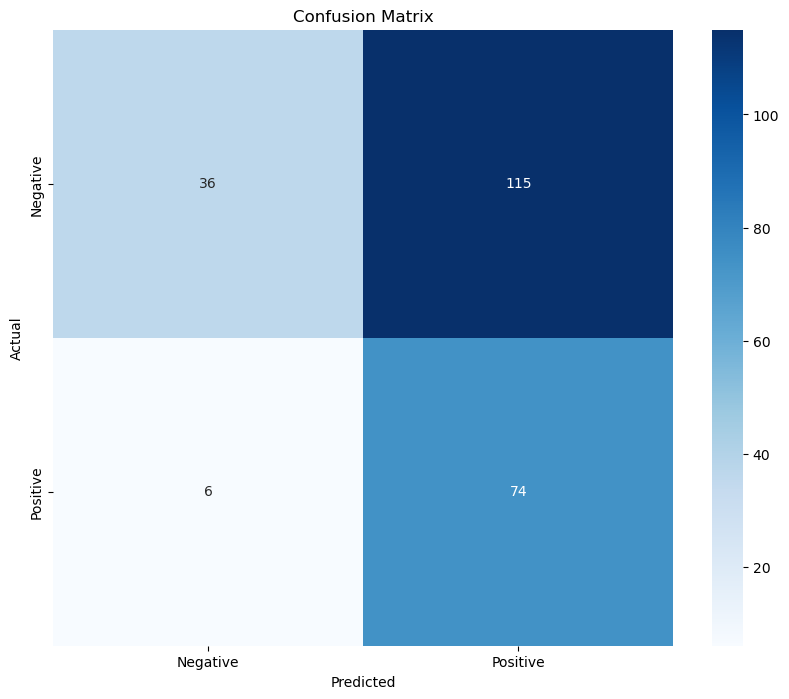

In [114]:
create_confusion_matrix(y_test_xgb_30_True,y_pred_binary_xgb_30_True)

In [116]:
xgb_dict

{'0.4_Shuffle_True': [{'Accuracy': 0.4935064935064935,
   'Precision': 0.3702127659574468,
   'Recall': 0.9157894736842105,
   'f1': 0.5272727272727272}],
 '0.3_Shuffle_True': [{'Accuracy': 0.47619047619047616,
   'Precision': 0.3915343915343915,
   'Recall': 0.925,
   'f1': 0.550185873605948}],
 '0.2_Shuffle_True': [{'Accuracy': 0.45454545454545453,
   'Precision': 0.3937007874015748,
   'Recall': 0.8771929824561403,
   'f1': 0.5434782608695652}],
 '0.4_Shuffle_False': [{'Accuracy': 0.5746753246753247,
   'Precision': 0.31446540880503143,
   'Recall': 0.6944444444444444,
   'f1': 0.43290043290043295}],
 '0.3_Shuffle_False': [{'Accuracy': 0.45021645021645024,
   'Precision': 0.26380368098159507,
   'Recall': 0.86,
   'f1': 0.40375586854460094}],
 '0.2_Shuffle_False': [{'Accuracy': 0.7337662337662337,
   'Precision': 0.4523809523809524,
   'Recall': 0.5135135135135135,
   'f1': 0.48101265822784806}]}

In [117]:
rf_dict

{'0.4_Shuffle_True': [{'Accuracy': 0.4155844155844156,
   'Precision': 0.3420074349442379,
   'Recall': 0.968421052631579,
   'f1': 0.5054945054945055}],
 '0.3_Shuffle_True': [{'Accuracy': 0.4155844155844156,
   'Precision': 0.36585365853658536,
   'Recall': 0.9375,
   'f1': 0.5263157894736842}],
 '0.2_Shuffle_True': [{'Accuracy': 0.37012987012987014,
   'Precision': 0.37012987012987014,
   'Recall': 1.0,
   'f1': 0.5402843601895735}],
 '0.4_Shuffle_False': [{'Accuracy': 0.474025974025974,
   'Precision': 0.31363636363636366,
   'Recall': 0.8625,
   'f1': 0.46}],
 '0.3_Shuffle_False': [{'Accuracy': 0.6320346320346321,
   'Precision': 0.3783783783783784,
   'Recall': 0.7241379310344828,
   'f1': 0.49704142011834324}],
 '0.2_Shuffle_False': [{'Accuracy': 0.48484848484848486,
   'Precision': 0.2839506172839506,
   'Recall': 0.9387755102040817,
   'f1': 0.4360189573459715}]}

In [118]:
dt_dict

{'0.4_Shuffle_True': [{'Accuracy': 0.4090909090909091,
   'Precision': 0.33073929961089493,
   'Recall': 0.8947368421052632,
   'f1': 0.4829545454545454}],
 '0.3_Shuffle_True': [{'Accuracy': 0.4199134199134199,
   'Precision': 0.36082474226804123,
   'Recall': 0.875,
   'f1': 0.510948905109489}],
 '0.2_Shuffle_True': [{'Accuracy': 0.38311688311688313,
   'Precision': 0.375,
   'Recall': 1.0,
   'f1': 0.5454545454545454}],
 '0.4_Shuffle_False': [{'Accuracy': 0.4707792207792208,
   'Precision': 0.31336405529953915,
   'Recall': 0.8292682926829268,
   'f1': 0.45484949832775917}],
 '0.3_Shuffle_False': [{'Accuracy': 0.4199134199134199,
   'Precision': 0.2603550295857988,
   'Recall': 0.8301886792452831,
   'f1': 0.3963963963963964}],
 '0.2_Shuffle_False': [{'Accuracy': 0.4588744588744589,
   'Precision': 0.31547619047619047,
   'Recall': 0.8412698412698413,
   'f1': 0.45887445887445893}]}

### AutoGluon

In [136]:
from autogluon.tabular import TabularDataset, TabularPredictor

df_auto = data.drop(['Triggers', 'Motivations','Outcomes'],axis=1)
df_train,df_test=train_test_split(df_auto,test_size=0.3,random_state=1,shuffle=False)
rows_to_duplicate = df_train[df_train['Protests with a significant outcome'] == 1]
df_train = pd.concat([df_train, rows_to_duplicate, rows_to_duplicate], ignore_index=False)
print(df_train.shape,df_test.shape)
test_data=df_test.drop(['Protests with a significant outcome'],axis=1)

(749, 9) (231, 9)


In [196]:
predictor= TabularPredictor(label = 'Protests with a significant outcome',eval_metric='f1').fit(train_data = df_train)

No path specified. Models will be saved in: "AutogluonModels/ag-20250202_083820"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:21:53 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T6020
CPU Count:          10
Memory Avail:       3.47 GB / 16.00 GB (21.7%)
Disk Space Avail:   199.24 GB / 460.43 GB (43.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy

[1000]	valid_set's binary_logloss: 0.517443	valid_set's f1: 0.711111


	0.7482	 = Validation score   (f1)
	2.59s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's binary_logloss: 0.454167	valid_set's f1: 0.808824


	0.8261	 = Validation score   (f1)
	1.96s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.7862	 = Validation score   (f1)
	0.23s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.7832	 = Validation score   (f1)
	0.18s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: CatBoost ...
	0.8175	 = Validation score   (f1)
	0.72s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.8	 = Validation score   (f1)
	0.18s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.8058	 = Validation score   (f1)
	0.18s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
		module 'torch._C' has no attribute '_has_mps'
Detailed Traceback:
Traceback (most recent call last):
  File "/Users/mayairemozbayoglu/anaconda3/lib/python3.11/site-packages/autogluon/core/trainer/abstract_trainer.py", line 2106, in _train_and

In [197]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge   0.829630          f1       0.000814  1.658930                0.000814           1.658930            1       True         11
1   WeightedEnsemble_L2   0.829630          f1       0.001431  1.735212                0.000617           0.076282            2       True         12
2              LightGBM   0.826087          f1       0.002426  1.960243                0.002426           1.960243            1       True          4
3              CatBoost   0.817518          f1       0.000986  0.722038                0.000986           0.722038            1       True          7
4               XGBoost   0.808511          f1       0.002030  1.002379                0.002030           1.002379            1       True         10
5        ExtraTreesEntr   0.805755    

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestGini': 'RFModel',
  'RandomForestEntr': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesGini': 'XTModel',
  'ExtraTreesEntr': 'XTModel',
  'XGBoost': 'XGBoostModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.5755395683453237,
  'KNeighborsDist': 0.6212121212121211,
  'LightGBMXT': 0.7482014388489209,
  'LightGBM': 0.8260869565217391,
  'RandomForestGini': 0.7862068965517242,
  'RandomForestEntr': 0.7832167832167832,
  'CatBoost': 0.8175182481751825,
  'ExtraTreesGini': 0.7999999999999999,
  'ExtraTreesEntr': 0.8057553956834532,
  'XGBoost': 0.8085106382978724,
  'LightGBMLarge': 0.8296296296296297,
  'WeightedEnsemble_L2': 0.8296296296296297},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': ['KNeighborsUnif'],
  'KNeighborsDist

In [199]:
predictor.leaderboard(df_train, silent=True)

model  score_test  score_val eval_metric  pred_time_test  \
0         LightGBMLarge    0.854202   0.829630          f1        0.006974   
1   WeightedEnsemble_L2    0.854202   0.829630          f1        0.008168   
2      RandomForestEntr    0.837696   0.783217          f1        0.049412   
3      RandomForestGini    0.836237   0.786207          f1        0.053267   
4               XGBoost    0.833333   0.808511          f1        0.026866   
5        ExtraTreesEntr    0.830123   0.805755          f1        0.047269   
6        ExtraTreesGini    0.828671   0.800000          f1        0.049707   
7              CatBoost    0.827957   0.817518          f1        0.002694   
8              LightGBM    0.805009   0.826087          f1        0.016287   
9        KNeighborsDist    0.630952   0.621212          f1        0.004261   
10           LightGBMXT    0.611465   0.748201          f1        0.023363   
11       KNeighborsUnif    0.479482   0.575540          f1        0.005840   

    pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0        0.000814  1.658930                 0.006974                0.000814   
1        0.001431  1.735212                 0.001194                0.000617   
2        0.015021  0.183291                 0.049412                0.015021   
3        0.015776  0.225759                 0.053267                0.015776   
4        0.002030  1.002379                 0.026866                0.002030   
5        0.015443  0.182666                 0.047269                0.015443   
6        0.014960  0.183257                 0.049707                0.014960   
7        0.000986  0.722038                 0.002694                0.000986   
8        0.002426  1.960243                 0.016287                0.002426   
9        0.002216  0.002174                 0.004261                0.002216   
10       0.002500  2.594985                 0.023363                0.002500   
11       0.007628  0.046621                 0.005840                0.007628   

    fit_time_marginal  stack_level  can_infer  fit_order  
0            1.658930            1       True         11  
1            0.076282            2       True         12  
2            0.183291            1       True          6  
3            0.225759            1       True          5  
4            1.002379            1       True         10  
5            0.182666            1       True          9  
6            0.183257            1       True          8  
7            0.722038            1       True          7  
8            1.960243            1       True          4  
9            0.002174            1       True          2  
10           2.594985            1       True          3  
11           0.046621            1       True          1

In [200]:
y_pred = predictor.predict(test_data)
y_pred=pd.DataFrame(y_pred,columns=['Protests with a significant outcome'])
y_pred

Protests with a significant outcome
537                                  0.0
538                                  0.0
539                                  0.0
540                                  0.0
541                                  0.0
..                                   ...
764                                  0.0
765                                  1.0
766                                  0.0
767                                  0.0
768                                  1.0

[231 rows x 1 columns]

In [143]:
y_pred.index

Int64Index([537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
            ...
            759, 760, 761, 762, 763, 764, 765, 766, 767, 768],
           dtype='int64', length=231)

In [201]:
y_test_auto = pd.DataFrame({'Protests with a significant outcome': y.loc[y_pred.index]})

In [202]:
predictor.evaluate(df_test)

{'f1': 0.288135593220339,
 'accuracy': 0.6363636363636364,
 'balanced_accuracy': 0.5367135761589403,
 'mcc': 0.09423661979701059,
 'roc_auc': 0.512955298013245,
 'precision': 0.4473684210526316,
 'recall': 0.2125}

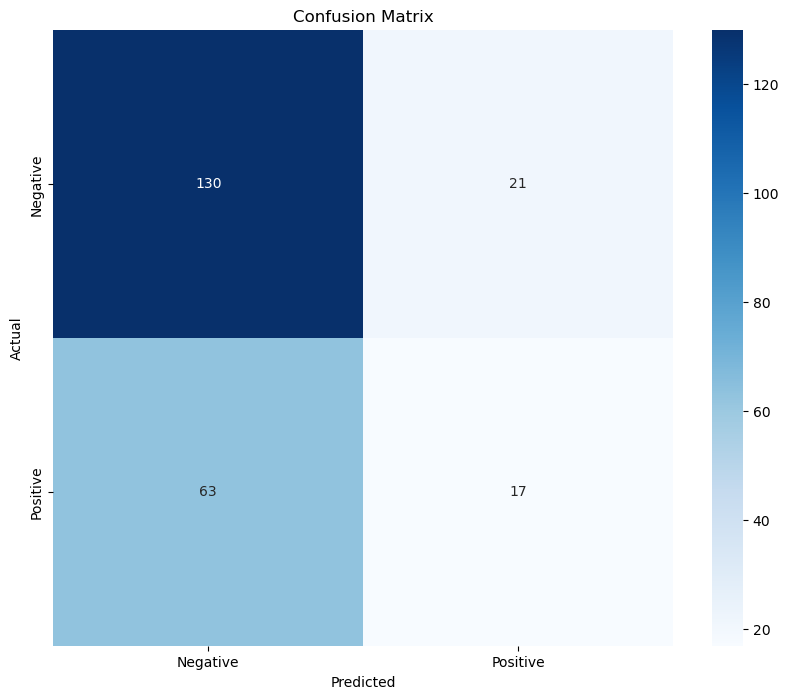

In [203]:
create_confusion_matrix(y_test_auto, y_pred)

#### Repeating the process to print feature importance without keeping the indexes

In [157]:
df_auto_2 = data.drop(['Triggers', 'Motivations','Outcomes'],axis=1)
df_train_2,df_test_2=train_test_split(df_auto_2,test_size=0.3,random_state=1,shuffle=False)
rows_to_duplicate = df_train_2[df_train_2['Protests with a significant outcome'] == 1]
df_train_2 = pd.concat([df_train_2, rows_to_duplicate, rows_to_duplicate], ignore_index=True)
print(df_train_2.shape,df_test_2.shape)

test_data_2=df_test_2.drop(['Protests with a significant outcome'],axis=1)
predictor_2= TabularPredictor(label = 'Protests with a significant outcome').fit(train_data = df_train_2)
predictor.feature_importance(data=df_train_2)

No path specified. Models will be saved in: "AutogluonModels/ag-20250201_134057"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:21:53 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T6020
CPU Count:          10
Memory Avail:       4.00 GB / 16.00 GB (25.0%)
Disk Space Avail:   203.79 GB / 460.43 GB (44.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy

(749, 9) (231, 9)


	0.6933	 = Validation score   (accuracy)
	1.05s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's binary_error: 0.173333


	0.84	 = Validation score   (accuracy)
	1.35s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.7933	 = Validation score   (accuracy)
	0.22s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.7933	 = Validation score   (accuracy)
	0.19s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: CatBoost ...
	0.8467	 = Validation score   (accuracy)
	0.54s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.8133	 = Validation score   (accuracy)
	0.19s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.82	 = Validation score   (accuracy)
	0.19s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
		module 'torch._C' has no attribute '_has_mps'
Detailed Traceback:
Traceback (most recent call last):
  File "/Users/mayairemozbayoglu/anaconda3/lib/python3.11/site-packages/autogluon/core/trainer/abstract_tr

importance    stddev   p_value  n  p99_high  \
Duration in days               0.268358  0.025049  0.000009  5  0.319934   
Peak Size                      0.167423  0.009563  0.000001  5  0.187113   
Economic motivation?           0.108945  0.012295  0.000019  5  0.134260   
Free                           0.096929  0.013765  0.000048  5  0.125272   
Violent government response    0.046195  0.008735  0.000146  5  0.064179   
Topic_5                        0.040320  0.004663  0.000021  5  0.049922   
Political motivation?          0.024833  0.002925  0.000023  5  0.030856   
Corruption motivation?         0.022964  0.004367  0.000150  5  0.031956   

                              p99_low  
Duration in days             0.216782  
Peak Size                    0.147734  
Economic motivation?         0.083630  
Free                         0.068586  
Violent government response  0.028210  
Topic_5                      0.030719  
Political motivation?        0.018810  
Corruption motivation?       0.013972

### Performing K-Fold Cross-Validation

In [165]:
from sklearn.model_selection import KFold
from openpyxl import Workbook
from sklearn.datasets import make_classification

# Initialize the k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Random forest model
# the number of estimators really made a difference here 
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize the DataFrame to collect results
comparison_df = pd.DataFrame()

# K-fold cross-validation
fold = 1
for train_index, test_index in kf.split(X):
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class on the training data
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    
    # Collect predictions and actual values for the training data
    fold_df = pd.DataFrame({
        'Index': train_index,
        f'Fold_{fold}_Pred': y_pred_proba_train,
        f'Fold_{fold}_Actual': y_train.values
    })
    
    # Merge results from each fold into the main DataFrame
    if comparison_df.empty:
        comparison_df = fold_df
    else:
        comparison_df = pd.concat([comparison_df, fold_df], ignore_index=True)
    
    fold += 1

# Sort results by index for consistency
comparison_df = comparison_df.sort_values('Index').reset_index(drop=True)

# Save the results to an Excel file
comparison_df.to_excel('training_predictions_kfold.xlsx', index=False)

print("Results saved to 'training_predictions_kfold.xlsx'.")

Results saved to 'training_predictions_kfold.xlsx'.


There were 767 data points before removing the outliers.

In [166]:
indexes_to_drop = [13, 30, 34, 35, 38, 48, 163, 186, 192, 232, 237, 240, 250, 257, 260, 271, 276, 297, 320, 330, 332, 333, 382, 393, 417, 421, 455, 505, 519, 546, 549, 580, 628, 677, 680, 682, 688, 693, 703, 704, 713, 725, 730, 754]
cleaned_df = data.copy()
# Drop rows by index and modify the original DataFrame
cleaned_df.drop(indexes_to_drop, inplace=True)

In [168]:
X_final = cleaned_df.drop(['Triggers', 'Motivations','Outcomes','Protests with a significant outcome'],axis=1)
y_final = cleaned_df['Protests with a significant outcome']

In [170]:
y_pred_rf_20_True_final, y_test_rf_20_True_final = prediction(X_final,y_final,0.2,True,'rf')
best_threshold_rf_2 = choose_threshold(y_pred_rf_20_True_final, y_test_rf_20_True_final)
y_pred_binary_rf_20_True_final, results = evaluate(y_pred_rf_20_True_final, best_threshold_rf_2, y_test_rf_20_True_final)
results

For a test size of 0.2 the distribution of the target variable after duplication is:
 0.0    478
1.0    303
Name: Protests with a significant outcome, dtype: int64
Best threshold: 0.65, Best f1-score: 0.5679012345679013 ,best accuracy: 0.5172413793103449


{'Accuracy': 0.5172413793103449,
 'Precision': 0.42201834862385323,
 'Recall': 0.8679245283018868,
 'f1': 0.5679012345679013}

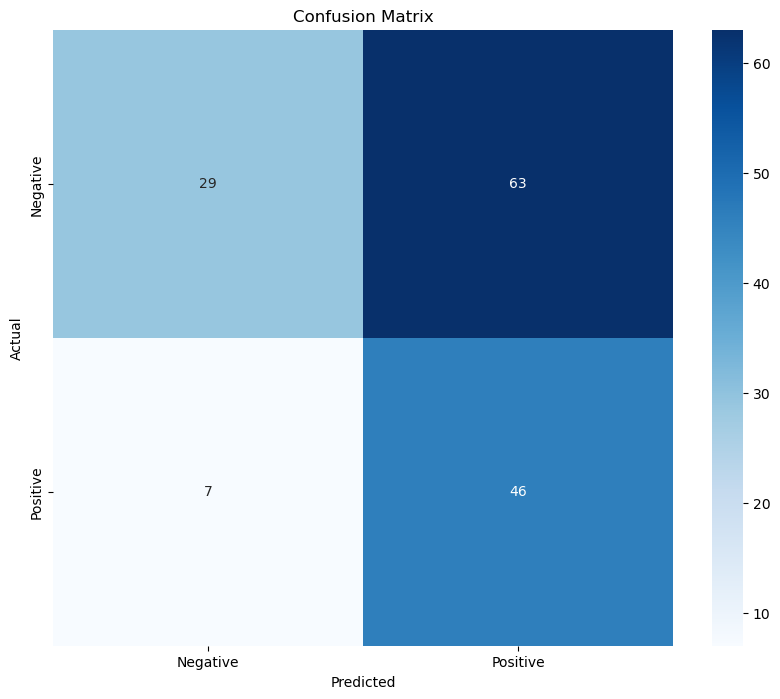

In [171]:
create_confusion_matrix(y_test_rf_20_True_final,y_pred_binary_rf_20_True_final)

### Moving on to actual predictions on the test set

In [207]:
def choose_threshold_2(y_pred_model,y_test):
    y_pred_positive = np.asarray(y_pred_model)
    best_threshold = 0
    best_score = 0
    
    for threshold in np.arange(0, 1, 0.01):
        y_pred_temp = (y_pred_positive >= threshold).astype(int) 
        score = f1_score(y_test, y_pred_temp)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    return best_threshold

In [214]:
def k_fold_test(number_of_splits, model, X, y):
    # Initialize k-fold parameters
    kf = KFold(n_splits=number_of_splits, shuffle=True, random_state=42)

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        rows_to_duplicate = X_train[y_train == 1]
        X_train = pd.concat([X_train, rows_to_duplicate, rows_to_duplicate], ignore_index=True)
        y_train = pd.concat([y_train, y_train[y_train == 1], y_train[y_train == 1]], ignore_index=True)
    
        model.fit(X_train, y_train)
    
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        threshold = choose_threshold_2(y_pred_proba, y_test)
        y_pred_binary = np.where((y_pred_proba >= threshold), 1, 0)

        # Print accuracy for each fold (optional)
        accuracy = accuracy_score(y_test, y_pred_binary)
        precision = precision_score(y_test, y_pred_binary)
        recall = recall_score(y_test, y_pred_binary)
        f1score = f1_score(y_test, y_pred_binary)
        print(f"Fold accuracy: {accuracy:.2f}")
        print(f"Fold precision: {precision:.2f}")
        print(f"Fold recall: {recall:.2f}")
        print(f"Fold f1score: {f1score:.2f}")
        
        create_confusion_matrix(y_test,y_pred_binary)

In [209]:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.7, 
                                      gamma= 0.3, learning_rate= 0.05, 
                                      max_depth= 9, min_child_weight= 7, 
                                      n_estimators= 68, subsample= 0.8563277359652208)
        
rf_model = RandomForestClassifier(n_estimators=50, bootstrap=True, criterion='gini', max_depth=3, max_features=3,
                            min_samples_leaf=7, min_samples_split=8)

dt_model = DecisionTreeClassifier(criterion="gini", max_depth=3, 
                               max_features=7,min_samples_leaf=5)

Fold accuracy: 0.77
Fold precision: 0.43
Fold recall: 0.67
Fold f1score: 0.52
Fold accuracy: 0.77
Fold precision: 0.41
Fold recall: 0.88
Fold f1score: 0.56
Fold accuracy: 0.61
Fold precision: 0.39
Fold recall: 0.78
Fold f1score: 0.52
Fold accuracy: 0.64
Fold precision: 0.36
Fold recall: 0.73
Fold f1score: 0.48
Fold accuracy: 0.69
Fold precision: 0.37
Fold recall: 0.63
Fold f1score: 0.46


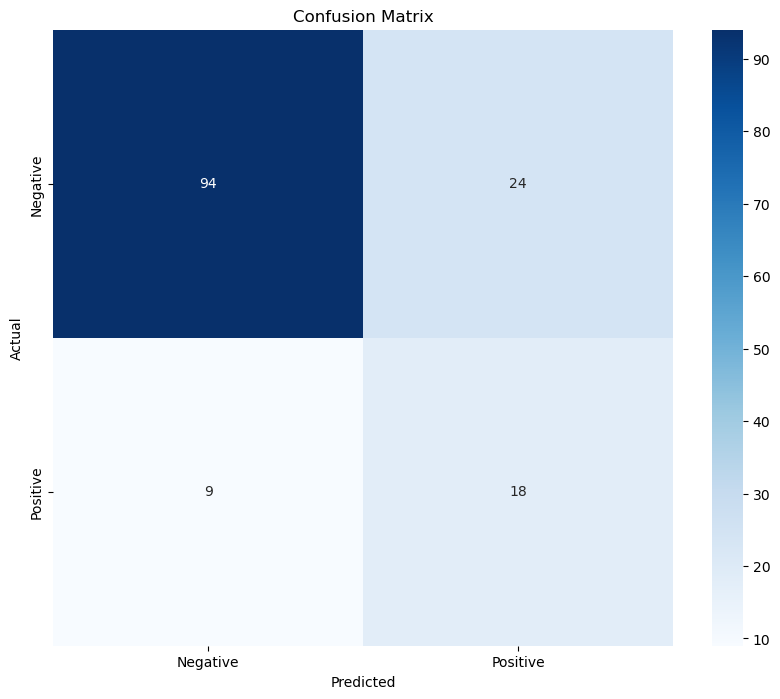

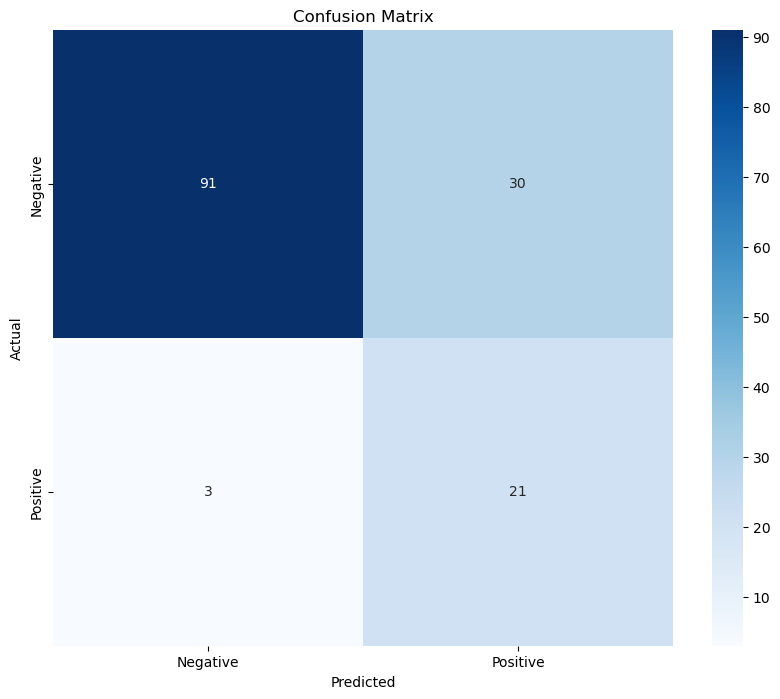

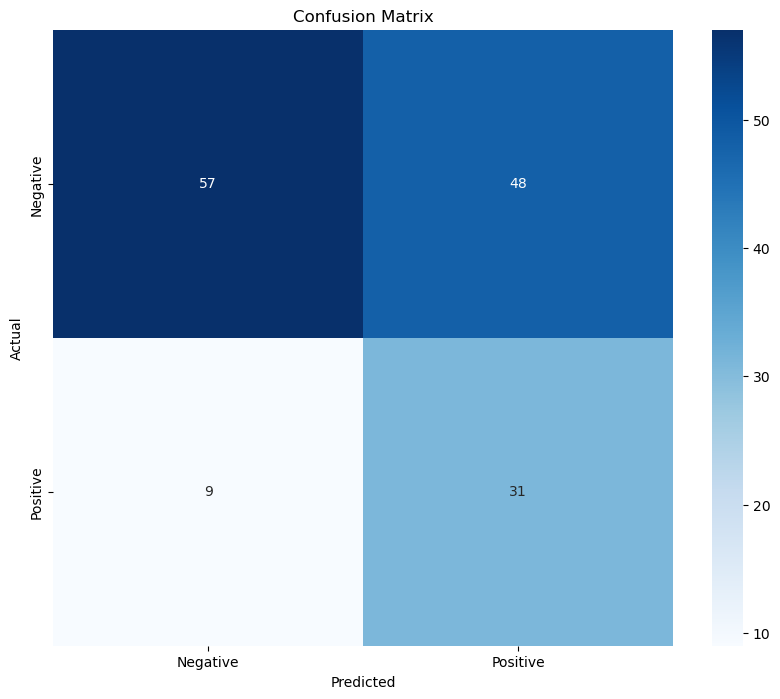

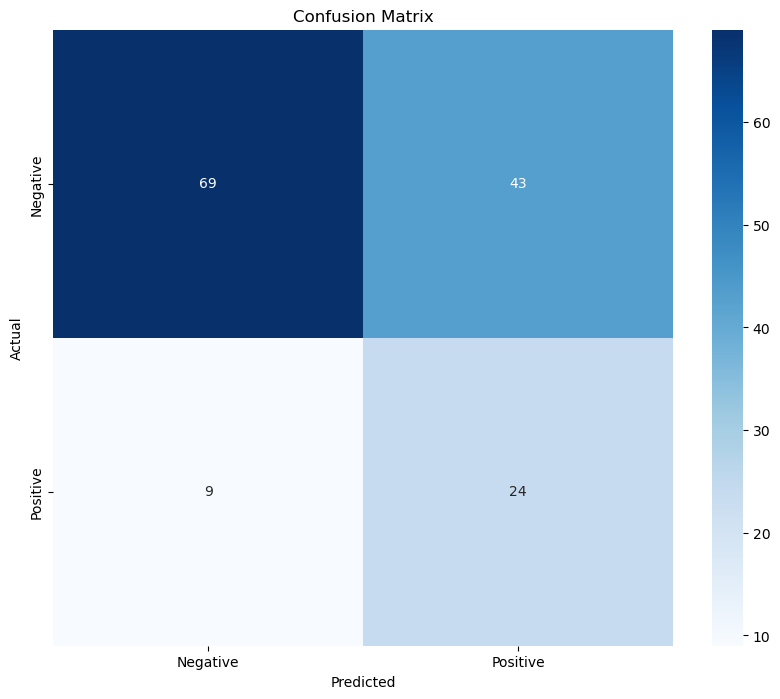

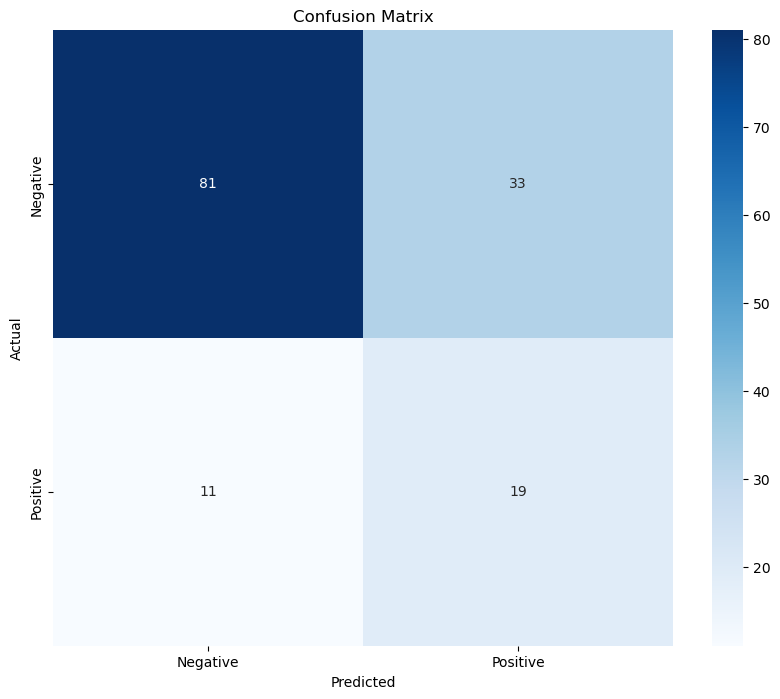

In [210]:
k_fold_test(5,xgb_model,X_final,y_final)

Fold accuracy: 0.80
Fold precision: 0.46
Fold recall: 0.44
Fold f1score: 0.45
Fold accuracy: 0.77
Fold precision: 0.40
Fold recall: 0.79
Fold f1score: 0.54
Fold accuracy: 0.56
Fold precision: 0.38
Fold recall: 0.95
Fold f1score: 0.54
Fold accuracy: 0.63
Fold precision: 0.36
Fold recall: 0.82
Fold f1score: 0.50
Fold accuracy: 0.67
Fold precision: 0.36
Fold recall: 0.80
Fold f1score: 0.50


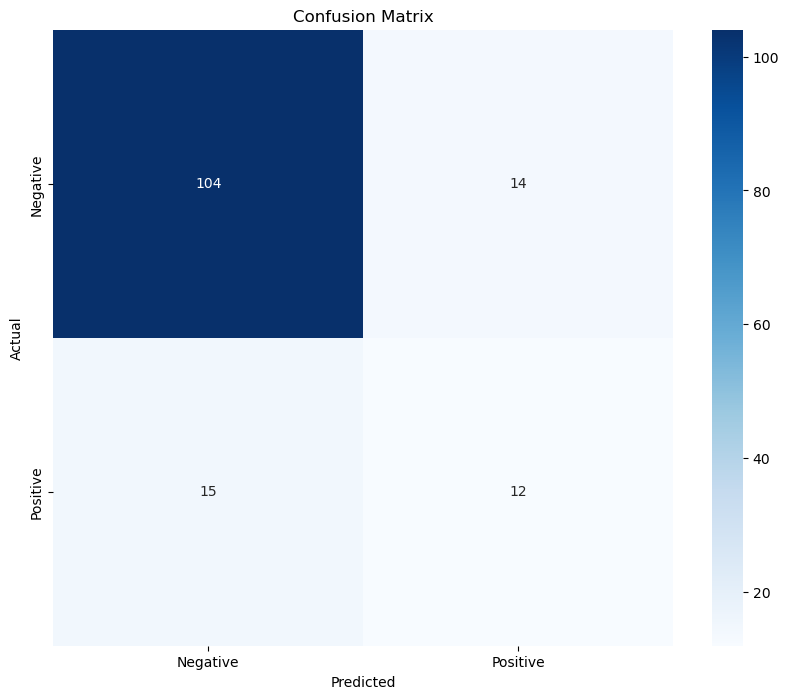

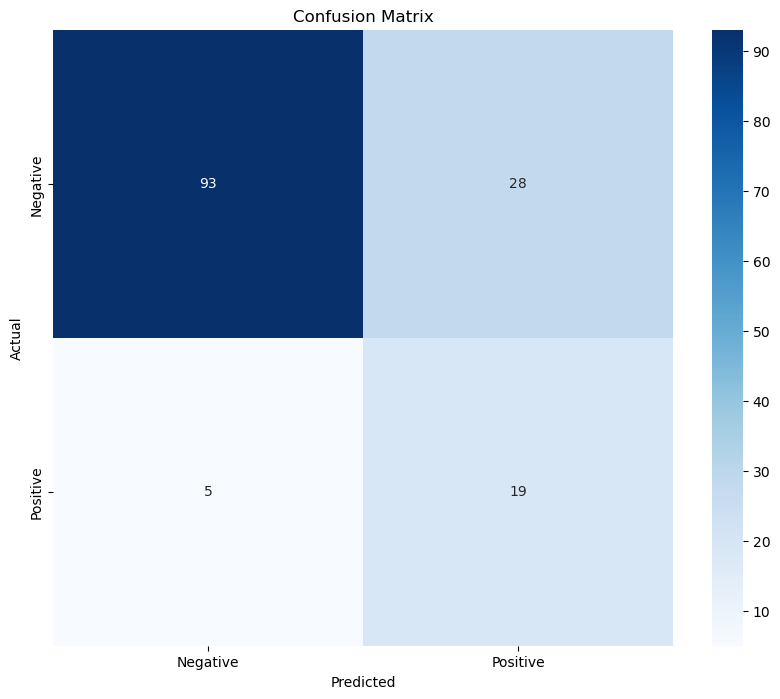

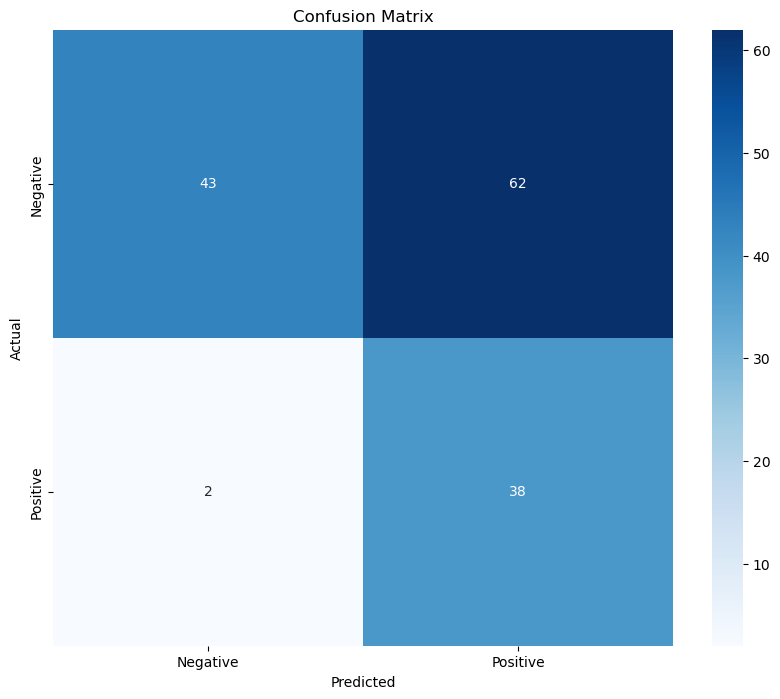

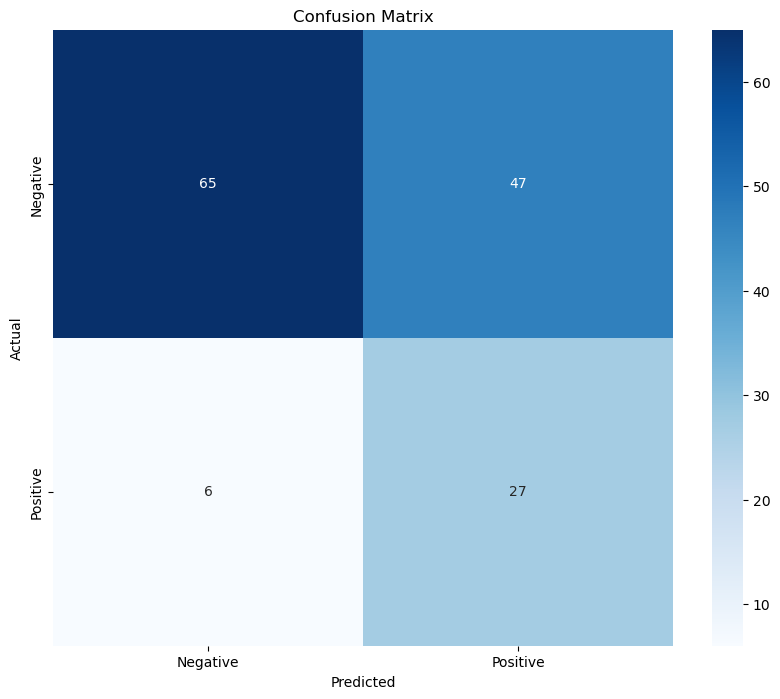

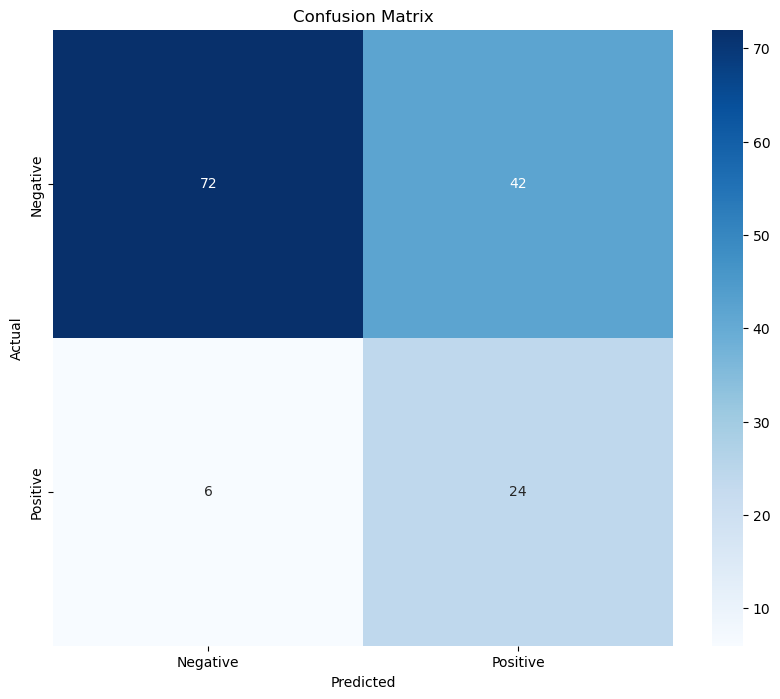

In [211]:
k_fold_test(5,rf_model,X_final,y_final)

Fold accuracy: 0.70
Fold precision: 0.32
Fold recall: 0.56
Fold f1score: 0.41
Fold accuracy: 0.49
Fold precision: 0.24
Fold recall: 0.96
Fold f1score: 0.38
Fold accuracy: 0.54
Fold precision: 0.37
Fold recall: 0.95
Fold f1score: 0.54
Fold accuracy: 0.67
Fold precision: 0.36
Fold recall: 0.58
Fold f1score: 0.44
Fold accuracy: 0.45
Fold precision: 0.27
Fold recall: 0.93
Fold f1score: 0.41


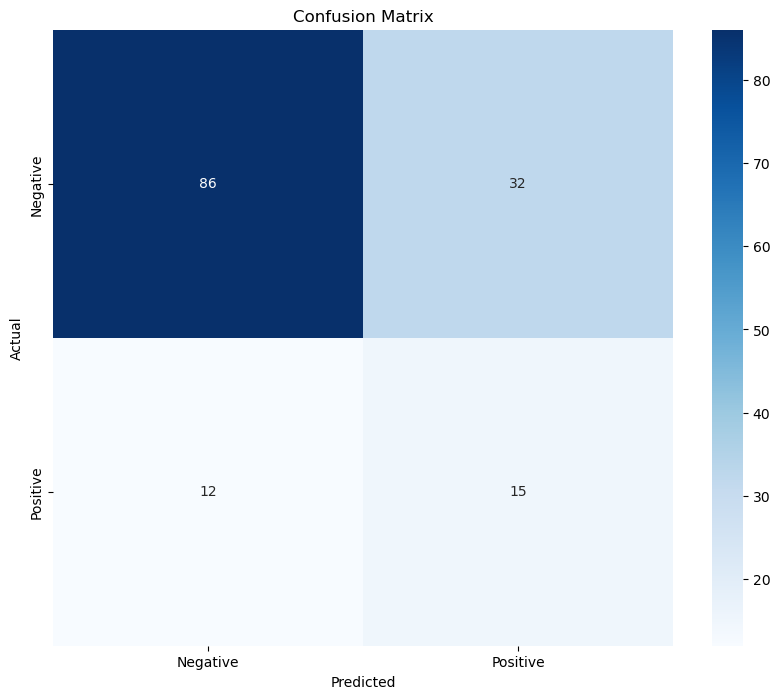

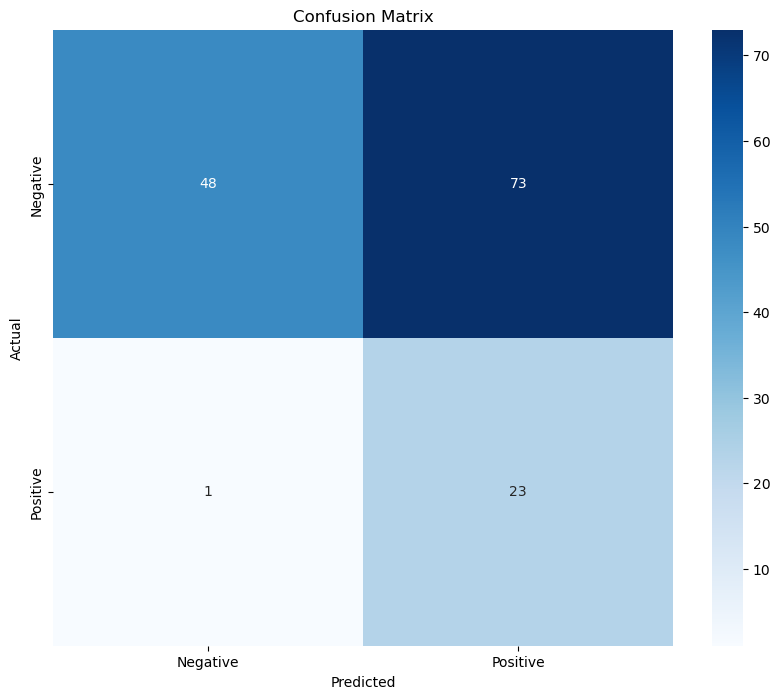

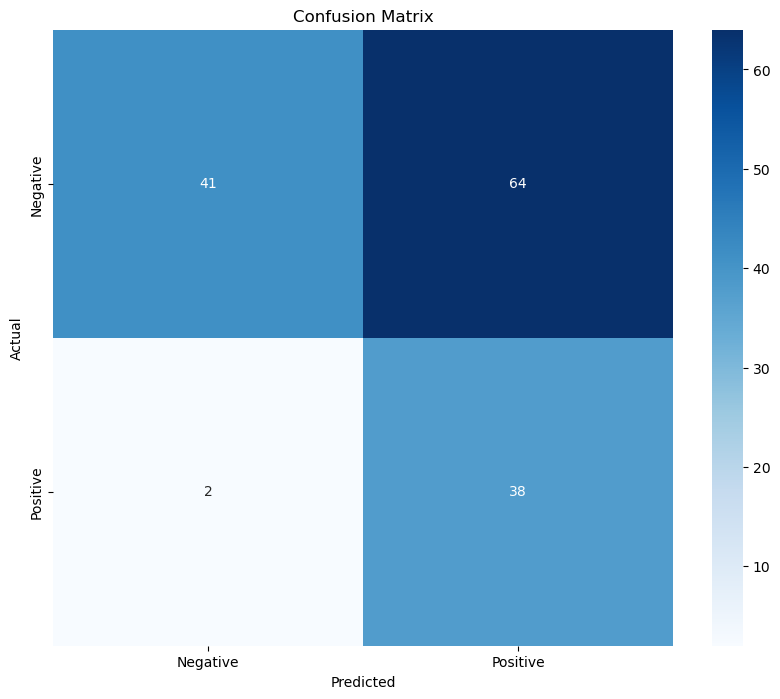

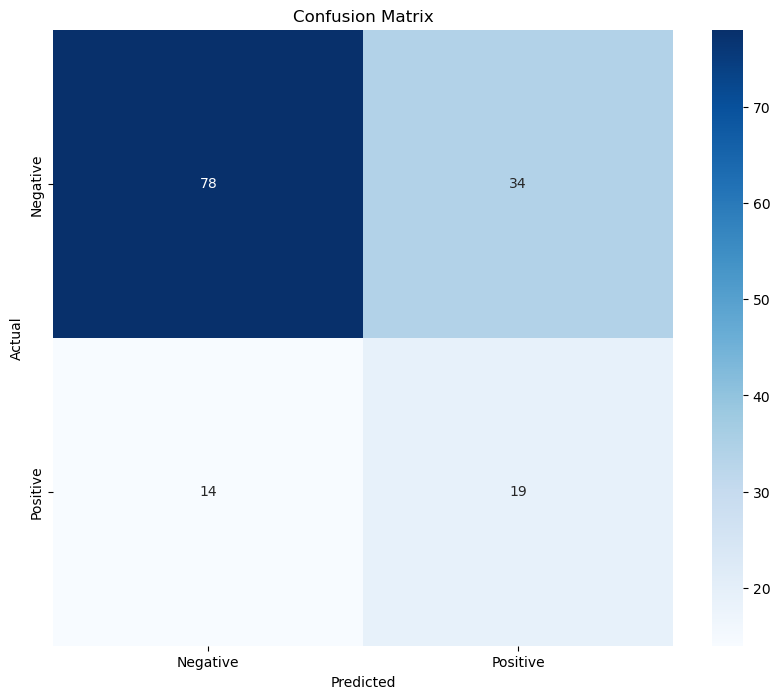

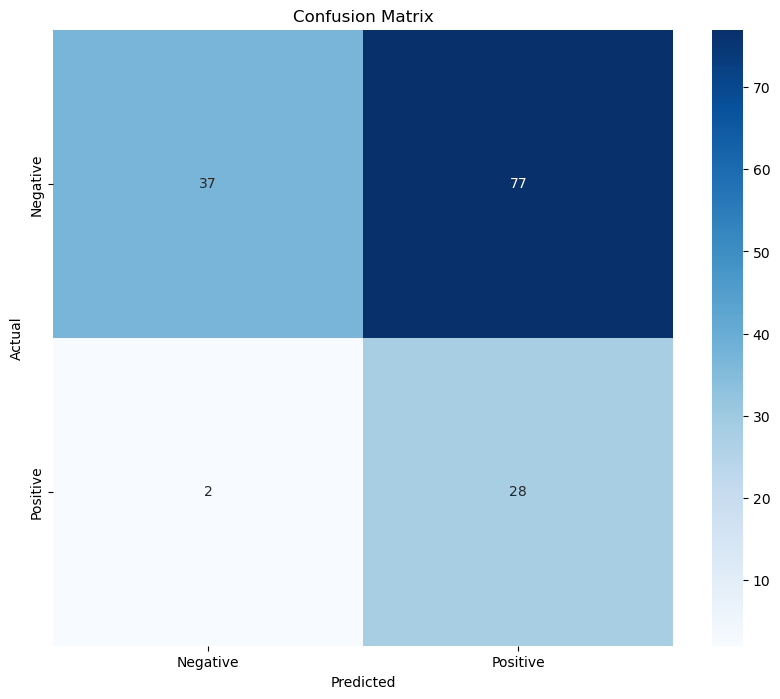

In [212]:
k_fold_test(5,dt_model,X_final,y_final)

Fold accuracy: 0.87
Fold precision: 0.67
Fold recall: 0.41
Fold f1score: 0.51
Fold accuracy: 0.76
Fold precision: 0.50
Fold recall: 0.53
Fold f1score: 0.52
Fold accuracy: 0.56
Fold precision: 0.33
Fold recall: 0.90
Fold f1score: 0.49
Fold accuracy: 0.59
Fold precision: 0.32
Fold recall: 0.78
Fold f1score: 0.46


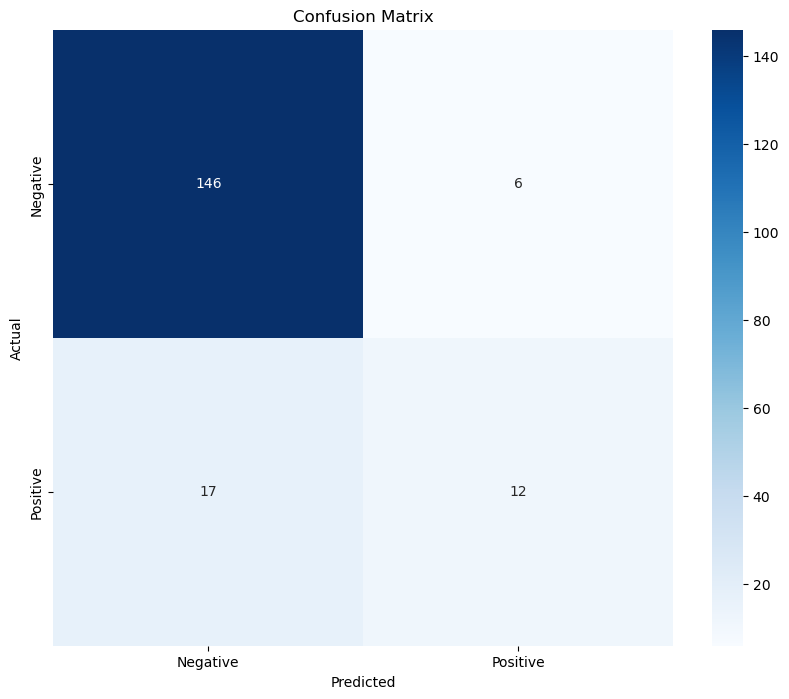

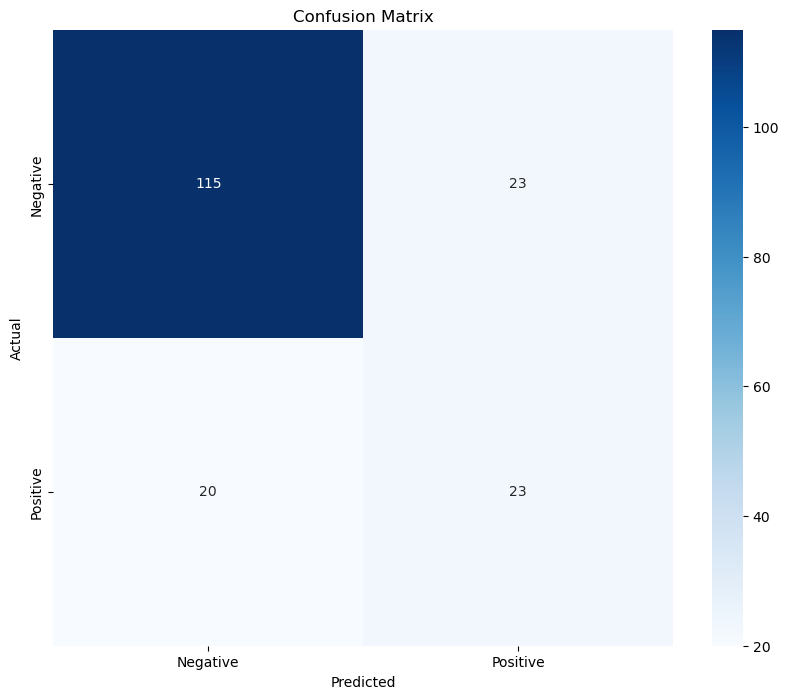

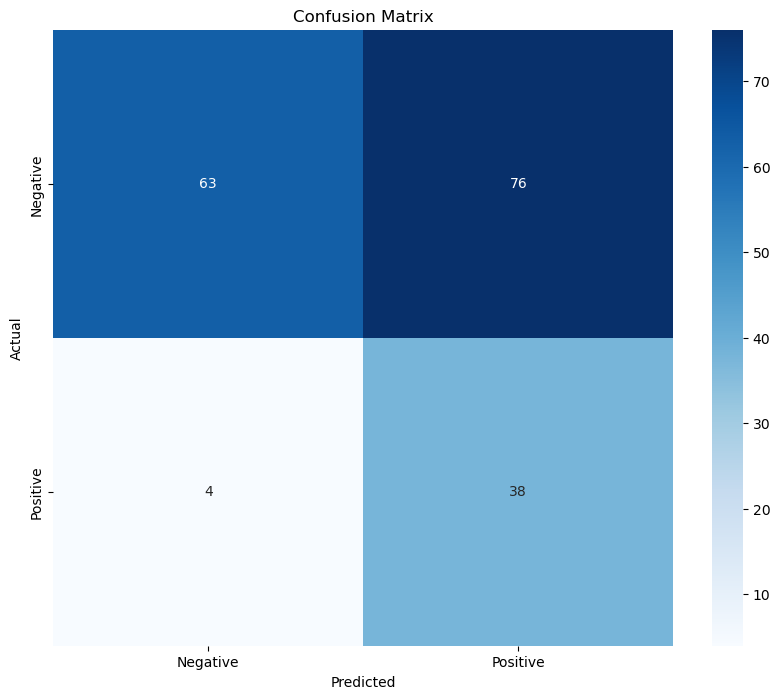

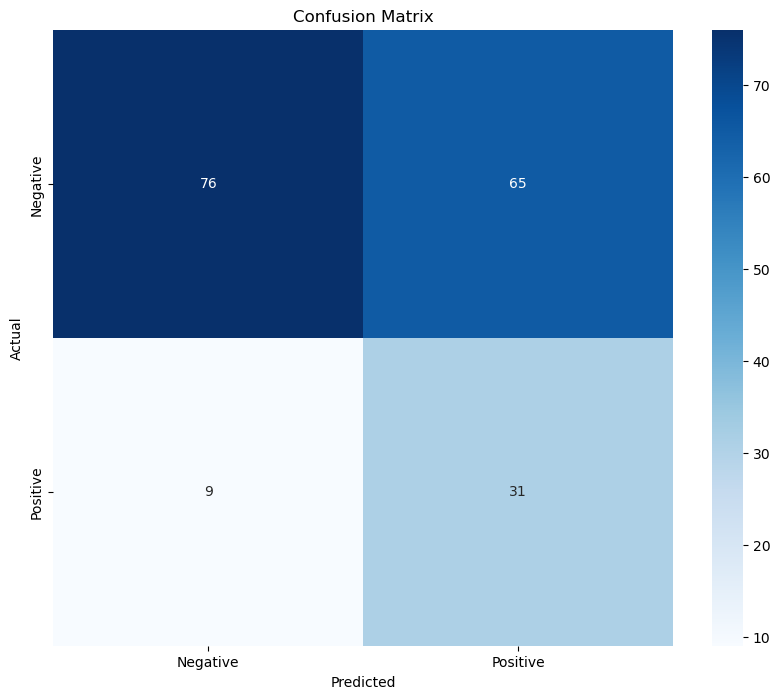

In [215]:
k_fold_test(4,xgb_model,X_final,y_final)

## Explainability

In [ ]:
xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.7, 
    gamma=0.3, 
    learning_rate=0.05, 
    max_depth=9, 
    min_child_weight=7, 
    n_estimators=68, 
    subsample=0.8563277359652208
)

SHAP Consistency Check: 4.76837158203125e-07


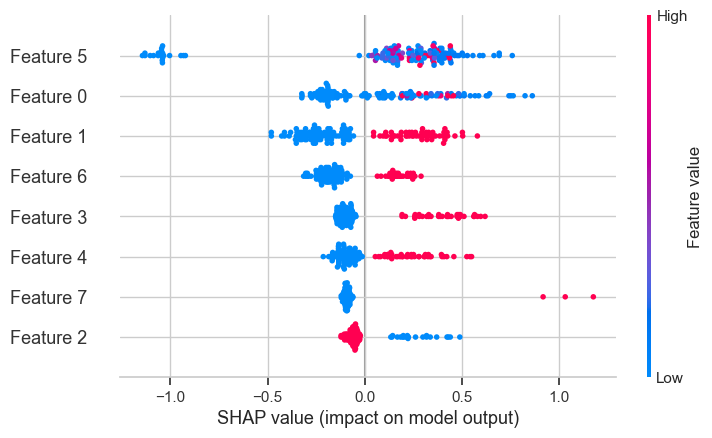

In [220]:
import xgboost
import shap
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, shuffle=False)
rows_to_duplicate = X_train[y_train == 1]
    
X_train = pd.concat([X_train, rows_to_duplicate, rows_to_duplicate], ignore_index=True)
y_train = pd.concat([y_train, y_train[y_train == 1], y_train[y_train == 1]], ignore_index=True)

# Convert training and testing data to DMatrix
X_train_dmatrix = xgboost.DMatrix(X_train, label=y_train)
X_test_dmatrix = xgboost.DMatrix(X_test, label=y_test)

# Defining the same parameters for xgboost.train as previously
params = {
    "objective": "binary:logistic",  
    "colsample_bytree": 0.7, 
    "gamma": 0.3, 
    "eta": 0.05,  
    "max_depth": 9, 
    "min_child_weight": 7, 
    "subsample": 0.8563277359652208
}

num_round = 68  # Equivalent to n_estimators in XGBClassifier
model = xgb.train(params, X_train_dmatrix, num_round)

# Making predictions on the test set (in raw margin space)
pred_test = model.predict(X_test_dmatrix, output_margin=True)

# Initializing SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculating SHAP values for the test set
explanation_test = explainer(X_test_dmatrix)

# Extracting SHAP values and base values
shap_values_test = explanation_test.values
base_values_test = explanation_test.base_values

# Verifying SHAP values consistency
consistency_check = np.abs(shap_values_test.sum(axis=1) + base_values_test - pred_test).max()
print(f"SHAP Consistency Check: {consistency_check}")

# Plotting SHAP values for the test set
shap.plots.beeswarm(explanation_test)

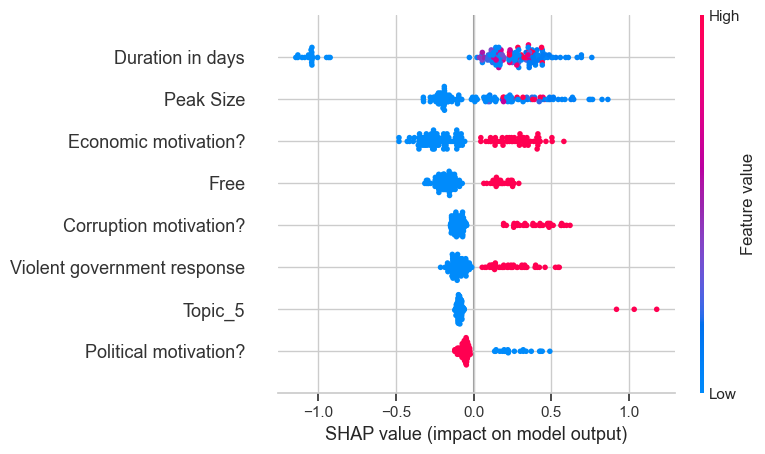

In [224]:
# Summarizing the effects of all the features
shap.summary_plot(shap_values_test,X_test)

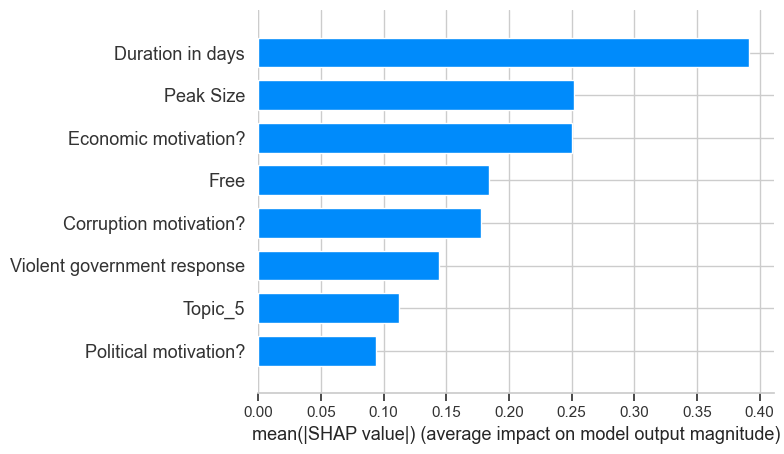

In [225]:
shap.summary_plot(shap_values_test,X_test, plot_type="bar")

PCA

In [93]:
import plotly.express as px
from sklearn.datasets import make_classification

# PCA
X, y = make_classification(
    n_features=8,
    n_classes=2,
    n_samples=1500,
    n_informative=2,
    random_state=5,
    n_clusters_per_class=1,
)


fig = px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], color=y, opacity=0.8)
fig.show()

In [94]:
from sklearn.manifold import TSNE

# TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y)
fig.update_layout(
    title="t-SNE visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Prediction - Part 2

In this section I will determine the target variable based on different NLP techniques. 

1. TF-IDF 

In [216]:
from sklearn.metrics.pairwise import cosine_similarity

# More preprocessing might be necessary in this case
# Initializing TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(strip_accents="ascii", lowercase=True, stop_words='english', ngram_range = (1,2), max_df = 0.99, min_df = 0.01, max_features=1000, norm = 'l2', binary = False)

# Fitting and transforming both columns (Motivations and Outcomes)
tfidf_motivations = tfidf_vectorizer.fit_transform(data['Motivations'])
tfidf_outcomes = tfidf_vectorizer.transform(data['Outcomes'])

# Computing cosine similarity between motivations and outcomes
similarity_scores = cosine_similarity(tfidf_motivations, tfidf_outcomes)

# Flattening diagonal of the similarity matrix (each row matches itself)
data['TF-IDF'] = [similarity_scores[i, i] for i in range(similarity_scores.shape[0])]
data[['Motivations','Outcomes','TF-IDF']]

Motivations  \
0                                                                                                                                                                                  Denounce Özer's removal from office as a political coup. Call for the resignation of President Recep Tayyip Erdoğan’s government.   
1                          Protest the election results, which many believe were rigged by the ruling party. Protesters are angry at the continuation of Frelimo's forty-nine-year rule, which has been marked by corruption and economic decline. They are also angry over the death of the two opposition figures.   
2                                                                    Call for Prime Minister Edi Rama to step down and for the government to be replaced by a caretaker cabinet before the 2025 parliamentary election. The opposition has repeatedly accused Rama and the Socialist Party of Albania of corruption.   
3                                                                                                                                                                                   Denounce the election results, which many—both within and outside Georgia—believe were the result of a flawed electoral process.   
4                                                       Criticize the Supreme Court ruling, which protesters believe to be unconstitutional since same-sex marriage is not legal. Protesters are also opposed to the LGBTQ+ community and argue that anti-discriminatory laws will result in reverse discrimination.   
..                                                                                                                                                                                                                                                                                                               ...   
764                                                                                                                                                                                    Concerns over a lack of genuine political pluralism, allegations of electoral manipulation, and the entrenchment of Kenyatta.   
765                                                                                                                                                                                               Discontent with government policies on farming, lack of government assistance, and stagnating incomes for farmers.   
766                                                                                                                                                                                           Economic challenges, inequality, corruption, political cronyism, and growing disapproval of then president Jacob Zuma.   
767                                                                                                                                                                                                                              Growing authoritarianism, economic crisis, and ensuing food and medicine shortages.   
768  Improper influence of outside individuals, including friends of politicians as well as business elites and family-run conglomerates; increasing class divisions and inequality and lack of social mobility and economic opportunity, especially for younger citizens; and patriarchy and sexism in South Korea.   

                                                                                                                                                                                                                                                                                                               Outcomes  \
0                                                                                                                                                                                                                                            

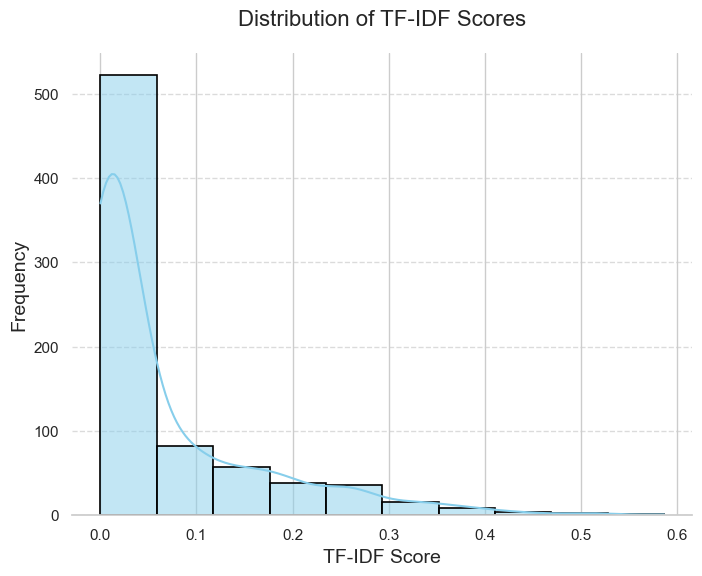

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hist(column):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], bins=10, kde=True, color='skyblue', edgecolor='black', linewidth=1.2)
    
    plt.title(f'Distribution of {column} Scores', fontsize=16, pad=20)
    plt.xlabel(f'{column} Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    
    sns.despine(left=True)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_hist('TF-IDF')

In [510]:
def tf_idf(score):
    if score > 0.1:
        return 1
    else:
        return 0
    
data['TF-IDF'] = data['TF-IDF'].apply(tf_idf)

In [499]:
data['Protests with a significant outcome'].value_counts()

0    582
1    186
Name: Protests with a significant outcome, dtype: int64

In [511]:
data['TF-IDF'].value_counts()

0    588
1    180
Name: TF-IDF, dtype: int64

In [526]:
# Calculating the similarity between TF-IDF and the target variable
from sklearn.metrics import cohen_kappa_score

kappa_tf_idf = cohen_kappa_score(data['Protests with a significant outcome'], data['TF-IDF'])
print(kappa_tf_idf)

0.21093925128894864


2. VADER 

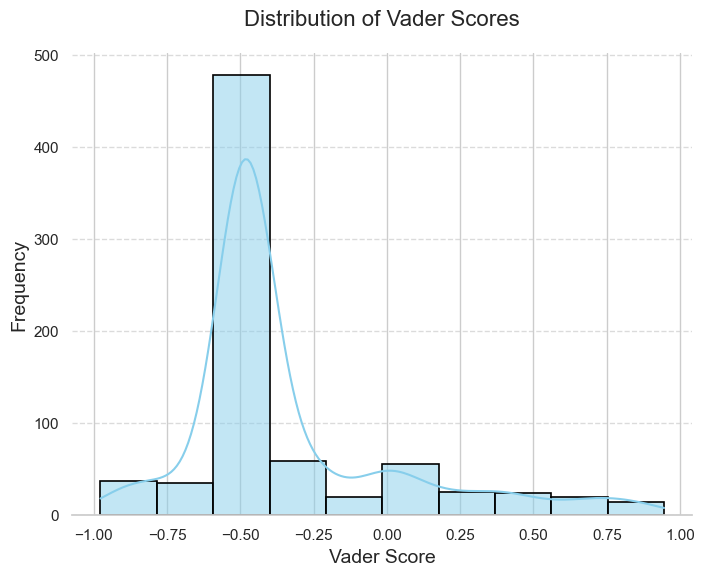

In [218]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# loading the VADER model of sentiment analysis
analyzer = SentimentIntensityAnalyzer()

def add_compound(row):
    score = analyzer.polarity_scores(row)
    return score['compound']

data['Vader'] = data['Outcomes'].apply(add_compound)
plot_hist('Vader')

In [524]:
def vader_binary(score):
    if score > 0:
        return 1
    else:
        return 0
    
data['Vader'] = data['Vader'].apply(vader_binary)
print(data['Protests with a significant outcome'].value_counts())
print(data['Vader'].value_counts())

0    582
1    186
Name: Protests with a significant outcome, dtype: int64
0    658
1    110
Name: Vader, dtype: int64


In [525]:
kappa_vader = cohen_kappa_score(data['Protests with a significant outcome'], data['Vader'])
print(kappa_vader)

0.21720097849877684


3. ABSA (Aspect-Based Sentiment Analysis)

In [527]:
from pyabsa import available_checkpoints
from pyabsa import ATEPCCheckpointManager

checkpoint_map = available_checkpoints()
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                                               auto_device=True) #False means load model on CPU

[2025-01-06 15:27:33] (2.4.1.post1) Please specify the task code, e.g. from pyabsa import TaskCodeOption
[2025-01-06 15:27:34] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2025-01-06 15:27:34] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2025-01-06 15:27:34] (2.4.1.post1) Downloading checkpoint:english 
[2025-01-06 15:27:34] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets
[2025-01-06 15:27:34] (2.4.1.post1) Checkpoint already downloaded, skip
[2025-01-06 15:27:34] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2025-01-06 15:27:34] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2025-01-0

/Users/mayairemozbayoglu/anaconda3/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



In [574]:
example = ['Camera quality is very good but battery drains fast.']
inference_source = example
atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,
                                               pred_sentiment=True)

[2025-01-08 12:04:09] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/mayairemozbayoglu/Documents/Research Paper/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2025-01-08 12:04:09] (2.4.1.post1) Example 0: Camera quality is very good but <battery:Negative Confidence:0.9986> drains fast .


In [576]:
atepc_result[0]['sentence']

'Camera quality is very good but battery drains fast .'

In [577]:
Positive = []
Neutral = []

def absa_binary(outcome):
    protest = [outcome]
    inference_source = protest
    atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,
                                               pred_sentiment=True)
    sentiment_list = atepc_result[0]['sentiment']
    sentence = atepc_result[0]['sentence']
    if 'Positive' in sentiment_list:
        Positive.append(sentence)
        return 1
    elif 'Neutral' in sentiment_list: 
        Neutral.append(sentence)
        return 1
    else:
        return 0
    
data['ABSA'] = data['Outcomes'].apply(absa_binary)
print(data['Protests with a significant outcome'].value_counts())
print(data['ABSA'].value_counts())
kappa_absa = cohen_kappa_score(data['Protests with a significant outcome'], data['ABSA'])
print(kappa_absa)

[2025-01-08 12:06:45] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/mayairemozbayoglu/Documents/Research Paper/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2025-01-08 12:06:45] (2.4.1.post1) Example 0: No policy / leadership change
[2025-01-08 12:06:46] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/mayairemozbayoglu/Documents/Research Paper/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2025-01-08 12:06:46] (2.4.1.post1) Example 0: No policy / leadership change . <Police:Negative Confidence:0.9983> violently cracked down on the protests , firing tear gas and killing at least ten demonstrators .
[2025-01-08 12:06:47] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/mayairemozbayoglu/Documents/Research Paper/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2025-01-08 12:06:47] (2.4.1.post1) Example 0: 

In [579]:
Positive

['The government scrapped plans to eliminate the diesel tax break for agricultural vehicles and announced a series of measures to ease financial and administrative burdens placed upon farmers . Prime Minister Gabriel Attal also confirmed France would remain opposed to the EU signing a free - trade agreement with the Mercosur trade group . In April 2024 , the EU approved legislation that eased the environmental rules of the Common Agricultural Policy ( CAP ) . In September 2024 , the European Commission announced that EU member states could increase the CAP funds provided to farmers .',
 'The prime minister apologized for any responsibility that the government had borne for the accident . He promised a swift investigation and said the new transportation minister would release a safety improvement plan . He also promised to name a commission to investigate mismanagement of the country ’ s railway system .',
 "On June 12 , the government announced that it will raise teachers ' pay by 25 p

In [580]:
Neutral

['No policy / leadership change . Three out of the four main opposition parties refused to accept the election results and announced that they would not take their seats in Parliament . The Central Election Commission reaffirmed the election results on October 31 after conducting a partial recount of the votes .',
 'Counterprotesters , most of whom were supporters of the Chega party , demonstrated in defense of the police . On October 25 , the officer who killed Moniz was indicted on murder charges .',
 'Demonstrators reached an agreement with the Ministry of Environment , which included commitments to advance the formalization of the mining sector and promote sustainable mining practices .',
 "No political party agreed to form a coalition government with the FPÖ . As such , President Alexander Van der Bellen asked incumbent Chancellor Karl Nehammer and his party , the conservative Austrian People ' s Party , to form a government .",
 'To prevent further demonstrations , the Karachi go